In [1]:
# 구글 드라이브에 연동하여 데이터셋 가져오기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir("/content/drive/MyDrive/exa_data")
os.getcwd()

import pandas as pd

customer_df = pd.read_csv('Customer.csv', sep=",")
transactions_df = pd.read_csv('Transactions.csv', sep=",")
prod_df = pd.read_csv('prod_cat_info.csv', sep=",")

In [3]:
# 한글 폰트 출력
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

- 2011년 시점을 기준으로 5세 단위로 연령 구간을 나누고 각 성별(gender), 연령 구간별로 고객 수를 Python 코드를 이용하여 집계해 주세요. (단, 고객의 성별, 연령 정보를 구할 수 없을 경우 해당 데이터는 집계에서 제외해 주세요.)


- 위에서 집계한 데이터를 기준으로 연령/성별 통계를 확인할 수 있는 데이터 시각화 자료를 작성해주세요.
2013년 2월 28일을 기준으로 각 고객의 구매 경과일수 및 구매주기를 구해주세요.
    - 구매 경과일수 = 기준일 - 마지막 구매일
    - 구매주기 = (마지막 구매일 - 첫 구매일)/(총 구매 일수 - 1)
- 위에서 구한 결과에 고객의 연령, 연령 구간, 성별 정보를 결합하여 특정 연령 구간, 성별 간 차이가 있는지 확인해주세요.
- 위에서 구한 고객별 구매 경과일수를 기준으로 구매 경과일수가 30일 이상인 고객을 대상으로 재구매 유도를 위한 캠페인을 진행하였다고 가정하겠습니다. 캠페인 2013년 12월 31일까지 구매 반응한 고객 수를 구해주세요.
- 전체 데이터에서 고객의 요일별 구매 건수 차이가 있는지 확인해주세요.
- 대 카테고리를 기준으로 2011년부터 2013년 월평균 매출액이 가장 높은 카테고리는 무엇인가요?
- 각 카테고리별 월평균 매출액의 분산과 표준 편차를 구해주세요.
- 각 카테고리에 대한 월평균 매출액과 표준 편차를 통해 현재 해당 서비스에서의 각 카테고리별 매출 성과를 판단해주세요.
    - [참고 자료] 변동 계수 https://namu.wiki/w/%EB%B3%80%EB%8F%99%EA%B3%84%EC%88%98

In [4]:
customer_df.head()

customer_Id         DOB Gender  city_code
0       268408  02-01-1970      M        4.0
1       269696  07-01-1970      F        8.0
2       268159  08-01-1970      F        8.0
3       270181  10-01-1970      F        2.0
4       268073  11-01-1970      M        1.0

In [5]:
transactions_df.head()

transaction_id  cust_id   tran_date  prod_subcat_code  prod_cat_code  Qty  \
0     80712190438   270351  28-02-2014                 1              1   -5   
1     29258453508   270384  27-02-2014                 5              3   -5   
2     51750724947   273420  24-02-2014                 6              5   -2   
3     93274880719   271509  24-02-2014                11              6   -3   
4     51750724947   273420  23-02-2014                 6              5   -2   

   Rate      Tax  total_amt Store_type  
0  -772  405.300  -4265.300     e-Shop  
1 -1497  785.925  -8270.925     e-Shop  
2  -791  166.110  -1748.110   TeleShop  
3 -1363  429.345  -4518.345     e-Shop  
4  -791  166.110  -1748.110   TeleShop

## tran_data 데이터타임으로 전처리

In [6]:
from datetime import datetime

# mm-dd-yy로 되어있는 데이터를 yy-mm-dd로 변경하는 함수
def object_to_datetime(date_str):
    # 날짜를 파싱하여 datetime 객체로 변환 (**-**-**** 형식과 **/**/****형식 두가지 존재)
    try:
        date_obj = datetime.strptime(date_str, '%d-%m-%Y')
    except:
        date_obj = datetime.strptime(date_str, '%d/%m/%Y')
    # 새로운 형식으로 날짜를 포멧후 데이터 타임으로 변경
    new_date_str = date_obj.strftime('%Y-%m-%d')
    return new_date_str

# 'DOB' 컬럼의 날짜 형식 변경
customer_df['DOB'] = customer_df['DOB'].apply(object_to_datetime)

# 'tran_date' 컬럼의 날짜 형식 변경
transactions_df['tran_date'] = transactions_df['tran_date'].apply(object_to_datetime)


In [7]:
# 날짜 형식 변경
customer_df['DOB'] = pd.to_datetime(customer_df['DOB'])

# 2011년 기준으로 연령 컬럼 생성
customer_df['age'] = 2011 - customer_df['DOB'].dt.year

# 5년 주기로 구간 나누기
customer_df['age'] = (customer_df['age'] // 5) * 5

# groupby로 성별과 나이를 집계
customer_group = customer_df.groupby(['Gender', 'age']).count().unstack(fill_value=0)['DOB']

In [8]:
customer_group

age      15   20   25   30   35   40
Gender                              
F       141  614  592  578  596  232
M       120  637  606  662  626  241

In [9]:
customer_group.columns

Int64Index([15, 20, 25, 30, 35, 40], dtype='int64', name='age')

# 여성과 남성의 연령 분포 시각화 (막대)

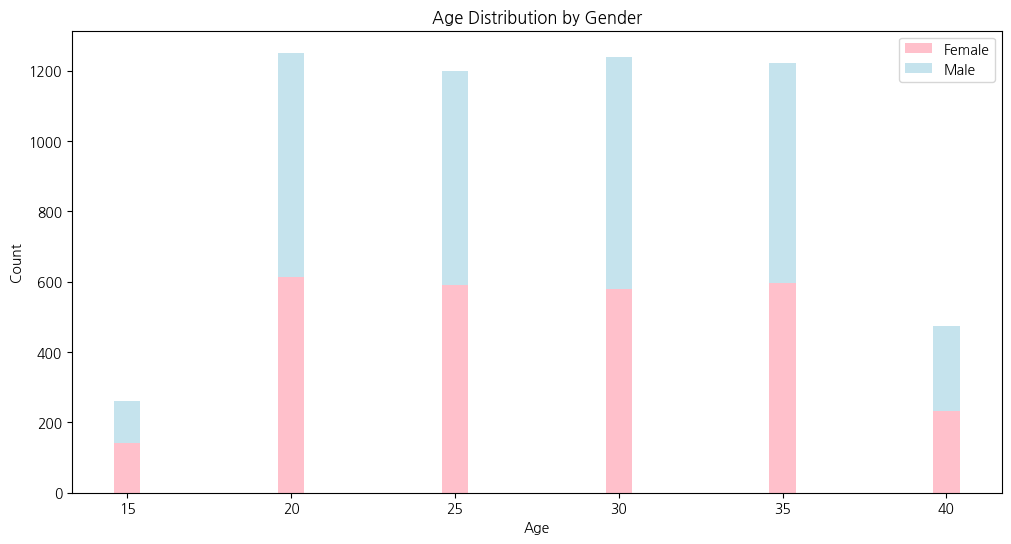

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# 여성 막대그래프
plt.bar(customer_group.columns, customer_group.loc['F'], label='Female', color='pink')

# 남성 막대그래프
plt.bar(customer_group.columns, customer_group.loc['M'], bottom=customer_group.loc['F'], label='Male', color='lightblue', alpha=0.7)

# 그래프 제목과 레이블 설정
plt.title('Age Distribution by Gender')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()

plt.show()

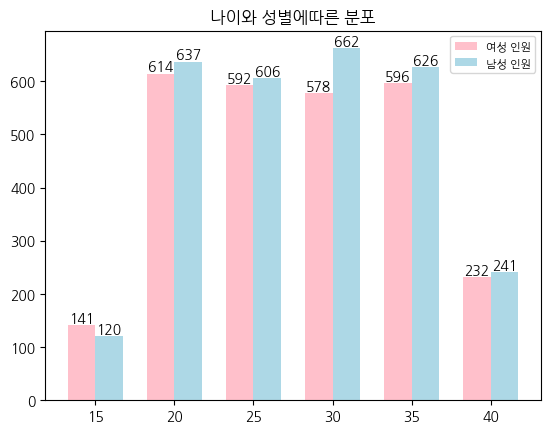

In [11]:
import numpy as np
# 그룹의 레이블 설정
labels = customer_group.columns
# 막대의 너비 설원
bar_width = 0.35
index = np.arange(len(labels))

# A 그룹과 B 그룹의 막대 그래프 생성
bars1 = plt.bar(index, customer_group.loc['F'], color='pink', label='여성 인원', width=bar_width, align='center')
bars2 = plt.bar(index + bar_width, customer_group.loc['M'], color='lightblue', label='남성 인원', width=bar_width, align='center')

# 막대 위에 값을 표시
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, '{:.0f}'.format(yval), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, '{:.0f}'.format(yval), ha='center', va='bottom')

# x축 레이블 설정
plt.xticks(index + bar_width / 2, labels)
# 제목 정하기
plt.title('나이와 성별에따른 분포')
# 범례 표시
plt.legend(loc = 'best',fontsize=8)

# 여백 없이 그림 합치기
plt.show()

15~20 구간은 여성 사용자가 더 많지만 나머지 연령 구간에서는 남성 사용자가 더 많은것을 알 수 있다.

30~35 구간에서는 남성 사용자 수와 여성 사용자 수의 차이가 제일 큰 크다.

## 구매주기와 구매 경과일수 계산


In [12]:
import pandas as pd

transactions_df['tran_date'] = pd.to_datetime(transactions_df['tran_date'])


# 각 고객의 첫 번째 및 마지막 구매일 찾기
first_purchase_dates = transactions_df.groupby('cust_id')['tran_date'].min()
last_purchase_dates = transactions_df.groupby('cust_id')['tran_date'].max()
count_purchase_dates = transactions_df.groupby('cust_id')['tran_date'].size()

# 2013년 2월 28일과의 구매 경과일수 계산
base_date = pd.to_datetime('2013-02-28')
purchase_elapsed_days = base_date - last_purchase_dates

# 구매 주기 계산
total_purchase_days = (last_purchase_dates - first_purchase_dates).dt.days + 1
purchase_cycle = (last_purchase_dates - first_purchase_dates) / (count_purchase_dates - 1)


# 결과 출력
result_df = pd.DataFrame({
    '첫구매일': first_purchase_dates,
    '마지막구매일': last_purchase_dates,
    '구매경과일수': purchase_elapsed_days,
    '구매주기': purchase_cycle
})

# 구매 경과 일수를 사용하여 현재 시점에 맞는 데이터 고르기
result_df = result_df[result_df['구매경과일수']>=pd.Timedelta(days=0)]
# 첫구매일과 마지막 구매일이 같은 경우 구매주기가 NaT으로 저장되어 지기 때문에 0 Days로 변경
result_df['구매주기'] = result_df['구매주기'].fillna(pd.Timedelta(days=0))
result_df

첫구매일     마지막구매일   구매경과일수              구매주기
cust_id                                                 
266783  2011-09-23 2013-02-20   8 days 129 days 00:00:00
266784  2012-08-23 2012-12-04  86 days  51 days 12:00:00
266788  2011-06-12 2013-02-12  16 days 203 days 16:00:00
266803  2012-06-02 2012-06-02 271 days   0 days 00:00:00
266807  2011-10-27 2012-12-25  65 days 141 days 16:00:00
...            ...        ...      ...               ...
275242  2011-08-07 2011-08-07 571 days   0 days 00:00:00
275243  2011-05-14 2012-04-25 309 days 347 days 00:00:00
275251  2012-01-02 2012-09-01 180 days 243 days 00:00:00
275262  2011-08-13 2012-02-29 365 days 200 days 00:00:00
275264  2011-08-05 2011-10-08 509 days  64 days 00:00:00

[1595 rows x 4 columns]

In [13]:
# 조인으로 테이블 합치기
join_df = pd.merge(result_df, customer_df, left_on='cust_id', right_on='customer_Id', how='left')

# 구매주기와 구매경과일수 열의 데이터 타입 변환
join_df['구매주기'] = pd.to_timedelta(join_df['구매주기']).dt.days
join_df['구매경과일수'] = pd.to_timedelta(join_df['구매경과일수']).dt.days

# age와 Gender로 그룹화하여 구매주기와 구매경과일수의 평균 계산
result_cycle = join_df.groupby(['Gender','age'])[['구매주기', '구매경과일수']].mean().unstack(fill_value=0)['구매주기']
result_total = join_df.groupby(['Gender','age'])[['구매주기', '구매경과일수']].mean().unstack(fill_value=0)['구매경과일수']

In [14]:
result_cycle

age             15          20          25          30          35          40
Gender                                                                        
F       132.729730  115.080000  145.638554  168.450980  136.176166  152.887097
M       135.121212  131.883978  134.846561  120.521505  134.487013  133.166667

### 시각화

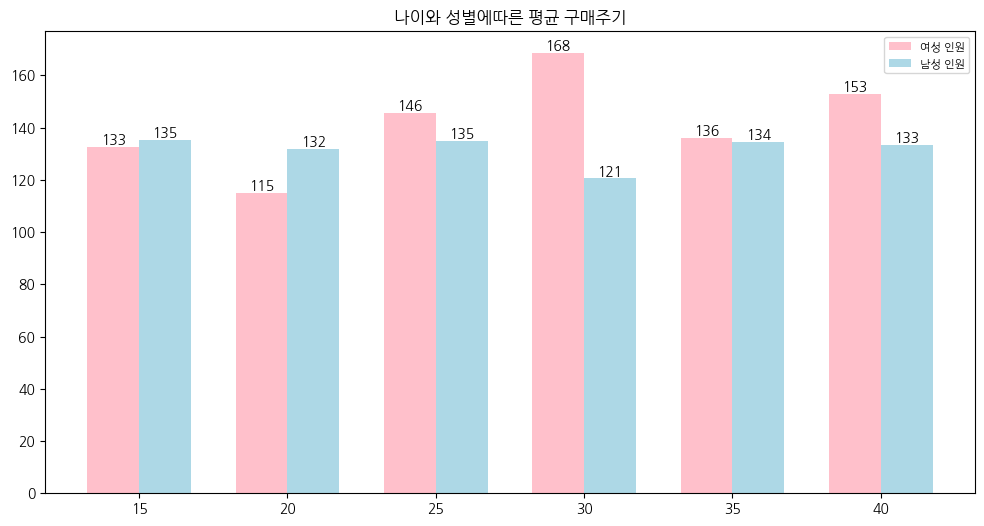

In [15]:
import numpy as np
# 그룹의 레이블 설정
labels = result_cycle.columns
# 막대의 너비 설원
bar_width = 0.35
index = np.arange(len(labels))

# 사이즈 조정
plt.figure(figsize=(12,6))
# A 그룹과 B 그룹의 막대 그래프 생성
bars1 = plt.bar(index, result_cycle.loc['F'], color='pink', label='여성 인원', width=bar_width, align='center')
bars2 = plt.bar(index + bar_width, result_cycle.loc['M'], color='lightblue', label='남성 인원', width=bar_width, align='center')

# 막대 위에 값을 표시
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, '{:.0f}'.format(yval), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, '{:.0f}'.format(yval), ha='center', va='bottom')

# x축 레이블 설정
plt.xticks(index + bar_width / 2, labels)
# 제목 정하기
plt.title('나이와 성별에따른 평균 구매주기')
# 범례 표시
plt.legend(loc = 'best',fontsize=8)

# 여백 없이 그림 합치기
plt.show()

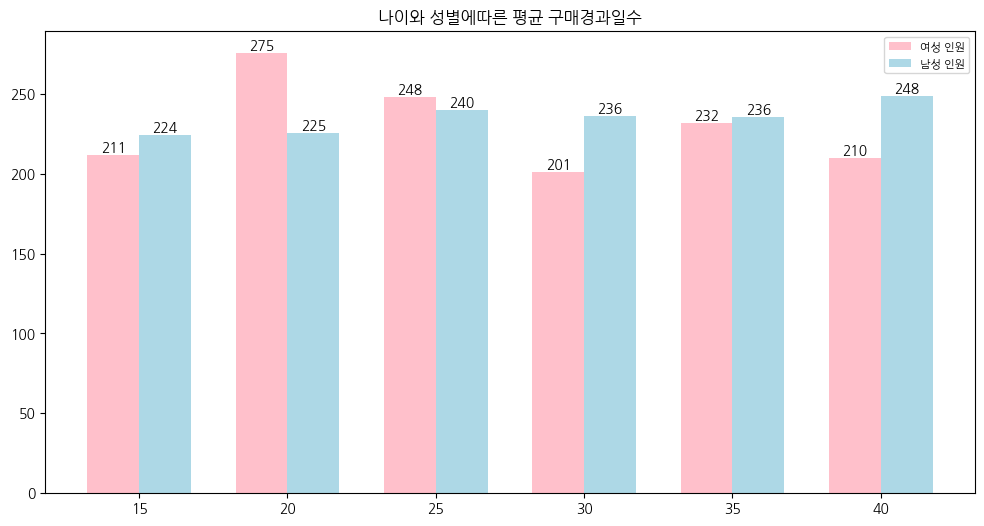

In [16]:
import numpy as np
# 그룹의 레이블 설정
labels = result_total.columns
# 막대의 너비 설원
bar_width = 0.35
index = np.arange(len(labels))

# 사이즈 조정
plt.figure(figsize=(12,6))
# A 그룹과 B 그룹의 막대 그래프 생성
bars1 = plt.bar(index, result_total.loc['F'], color='pink', label='여성 인원', width=bar_width, align='center')
bars2 = plt.bar(index + bar_width, result_total.loc['M'], color='lightblue', label='남성 인원', width=bar_width, align='center')

# 막대 위에 값을 표시
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, '{:.0f}'.format(yval), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, '{:.0f}'.format(yval), ha='center', va='bottom')

# x축 레이블 설정
plt.xticks(index + bar_width / 2, labels)
# 제목 정하기
plt.title('나이와 성별에따른 평균 구매경과일수')
# 범례 표시
plt.legend(loc = 'best',fontsize=8)

# 여백 없이 그림 합치기
plt.show()

# 매출 관점에서 카테고리별 매출 성장 방안 분석


## EDA
### 시간에 따른 총 매출의 변화 그래프

In [17]:
transactions_df.head()

transaction_id  cust_id  tran_date  prod_subcat_code  prod_cat_code  Qty  \
0     80712190438   270351 2014-02-28                 1              1   -5   
1     29258453508   270384 2014-02-27                 5              3   -5   
2     51750724947   273420 2014-02-24                 6              5   -2   
3     93274880719   271509 2014-02-24                11              6   -3   
4     51750724947   273420 2014-02-23                 6              5   -2   

   Rate      Tax  total_amt Store_type  
0  -772  405.300  -4265.300     e-Shop  
1 -1497  785.925  -8270.925     e-Shop  
2  -791  166.110  -1748.110   TeleShop  
3 -1363  429.345  -4518.345     e-Shop  
4  -791  166.110  -1748.110   TeleShop

In [18]:
# 일별로 저장되어있는 데이터를 월별로 수정하여 저장
transactions_df['tran_month'] = transactions_df['tran_date'].dt.to_period('M')

# 데이터프레임을 생성한 뒤, 'tran_month' 열의 값을 첫째 날짜로 변환하여 Timestamp 형식으로 변환
transactions_df['tran_month'] = transactions_df['tran_month'].dt.to_timestamp('D', 'start')

# 대 카테고리와 서브 카테고리를 하나의 컬럼으로 합침
transactions_df['category_code'] = transactions_df['prod_cat_code'] * 100 + transactions_df['prod_subcat_code']
prod_df['category_code'] = prod_df['prod_cat_code'] * 100 + prod_df['prod_sub_cat_code']
prod_df['category_name'] = prod_df['prod_cat'] + '/' + prod_df['prod_subcat']

# 조인으로 합치기 전 사용할 데이터만 선택
prod_df_j = prod_df[['category_name','category_code','prod_cat']]
transactions_df_j = transactions_df[['category_code','transaction_id','cust_id','tran_date','Qty','Rate','Tax','total_amt','Store_type','tran_month']]

# 조인으로 카테고리 코드를 카테고리 명칭으로 변경
join_df = pd.merge(transactions_df_j, prod_df_j, left_on='category_code', right_on='category_code', how='left')

In [19]:
# 'tran_date' 컬럼의 데이터가 2011년 1월인 행 삭제
join_df = join_df[(join_df['tran_date'].dt.year != 2011) | (join_df['tran_date'].dt.month != 1)]

## 매출 성과 지표

In [20]:
# 월별 서브 카테고리 매출의 평균 구하기
big_mean_df = join_df.groupby(['prod_cat', 'tran_month']).mean()['total_amt'].unstack(fill_value=0).T
# 2011년부터 2013년까지의 데이터 선택 (평균)
selected_big_mean_data = big_mean_df.loc['2011-01-01':'2013-12-31'].mean(axis=0)
# 2011년부터 2013년까지의 데이터 선택 (표준편차)
selected_big_std_data = big_mean_df.loc['2011-01-01':'2013-12-31'].std(axis=0)
# 2011년부터 2013년까지의 데이터 선택 (분산)
selected_big_var_data = big_mean_df.loc['2011-01-01':'2013-12-31'].var(axis=0)

# 월별 서브 카테고리 매출의 평균 구하기
sub_mean_df = join_df.groupby(['category_name', 'tran_month']).mean()['total_amt'].unstack(fill_value=0).T
# 2011년부터 2013년까지의 데이터 선택 (평균)
selected_sub_mean_data = sub_mean_df.loc['2011-01-01':'2013-12-31'].mean(axis=0)
# 2011년부터 2013년까지의 데이터 선택 (표준편차)
selected_sub_std_data = sub_mean_df.loc['2011-01-01':'2013-12-31'].std(axis=0)
# 2011년부터 2013년까지의 데이터 선택 (분산)
selected_sub_var_data = sub_mean_df.loc['2011-01-01':'2013-12-31'].var(axis=0)

# 월 카테고리별 변동계수 데이터 프레임 구하기
# 서브 카테고리
coef_var_sub_df = selected_sub_std_data/selected_sub_mean_data * 100
# 대 카테고리
coef_var_big_df = selected_big_std_data/selected_big_mean_data * 100

# 매출 성과 지수 (월 평균 카테고리 매출액 / 월 카테고리 변동 계수)
coef_var_big_df.sort_values(ascending=False)

<ipython-input-20-162996154472>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  big_mean_df = join_df.groupby(['prod_cat', 'tran_month']).mean()['total_amt'].unstack(fill_value=0).T
<ipython-input-20-162996154472>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sub_mean_df = join_df.groupby(['category_name', 'tran_month']).mean()['total_amt'].unstack(fill_value=0).T


prod_cat
Bags                15.325667
Clothing            12.907480
Home and kitchen    12.656824
Footwear            11.468892
Books                9.700823
Electronics          7.911415
dtype: float64

In [21]:
coef_var_sub_df.sort_values(ascending=False)

category_name
Clothing/Kids                      26.521506
Footwear/Women                     25.531152
Clothing/Women                     25.420528
Books/Comics                       25.379901
Books/Academic                     24.866708
Home and kitchen/Kitchen           24.694450
Home and kitchen/Furnishing        24.130086
Clothing/Mens                      23.851422
Home and kitchen/Bath              23.802537
Books/Non-Fiction                  23.272145
Books/DIY                          22.822095
Books/Fiction                      21.355484
Electronics/Computers              21.326764
Bags/Women                         21.320087
Bags/Mens                          21.073552
Footwear/Mens                      19.885281
Electronics/Personal Appliances    19.625786
Electronics/Audio and video        19.616961
Books/Children                     19.466430
Electronics/Mobiles                19.315555
Home and kitchen/Tools             18.200089
Electronics/Cameras                18.059

In [22]:
selected_big_mean_data.sort_values(ascending=False).head(1)

prod_cat
Electronics    2181.911
dtype: float64

In [23]:
selected_sub_mean_data.sort_values(ascending=False).head(1)

category_name
Electronics/Audio and video    2234.098845
dtype: float64

In [24]:
# 월별 서브 카테고리 매출의 평균 구하기
big_mean_df = join_df.groupby(['prod_cat', 'tran_month']).mean()['total_amt'].unstack(fill_value=0).T
# 2011년부터 2013년까지의 데이터 선택 (평균)
selected_big_mean_data = big_mean_df.mean(axis=0)
# 2011년부터 2013년까지의 데이터 선택 (표준편차)
selected_big_std_data = big_mean_df.std(axis=0)
# 2011년부터 2013년까지의 데이터 선택 (분산)
selected_big_var_data = big_mean_df.var(axis=0)

# 월별 서브 카테고리 매출의 평균 구하기
sub_mean_df = join_df.groupby(['category_name', 'tran_month']).mean()['total_amt'].unstack(fill_value=0).T
# 2011년부터 2013년까지의 데이터 선택 (평균)
selected_sub_mean_data = sub_mean_df.mean(axis=0)
# 2011년부터 2013년까지의 데이터 선택 (표준편차)
selected_sub_std_data = sub_mean_df.std(axis=0)
# 2011년부터 2013년까지의 데이터 선택 (분산)
selected_sub_var_data = sub_mean_df.var(axis=0)

# 월 카테고리별 변동계수 데이터 프레임 구하기
# 서브 카테고리
coef_var_sub_df = selected_sub_std_data/selected_sub_mean_data * 100
# 대 카테고리
coef_var_big_df = selected_big_std_data/selected_big_mean_data * 100

# 매출 성과 지수 (월 평균 카테고리 매출액 / 월 카테고리 변동 계수)
coef_var_big_df.sort_values(ascending=False)

<ipython-input-24-e3314e2fd8bc>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  big_mean_df = join_df.groupby(['prod_cat', 'tran_month']).mean()['total_amt'].unstack(fill_value=0).T
<ipython-input-24-e3314e2fd8bc>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sub_mean_df = join_df.groupby(['category_name', 'tran_month']).mean()['total_amt'].unstack(fill_value=0).T


prod_cat
Bags                15.153999
Clothing            13.701235
Home and kitchen    12.623058
Footwear            11.150552
Books                9.557941
Electronics          8.144101
dtype: float64

In [25]:
# 매출 성과 지수 (월 평균 카테고리 매출액 / 월 카테고리 변동 계수)
coef_var_sub_df.sort_values(ascending=False)

category_name
Clothing/Women                     28.241844
Clothing/Kids                      27.110990
Footwear/Women                     25.404913
Books/Comics                       25.234459
Books/Academic                     24.160740
Clothing/Mens                      24.080752
Home and kitchen/Kitchen           24.017511
Home and kitchen/Furnishing        23.832084
Books/Non-Fiction                  23.649792
Home and kitchen/Bath              23.492751
Books/DIY                          22.507913
Bags/Mens                          22.197581
Bags/Women                         21.988363
Electronics/Mobiles                21.871284
Electronics/Personal Appliances    21.369989
Electronics/Audio and video        20.996839
Books/Fiction                      20.857612
Electronics/Computers              20.771837
Books/Children                     19.822410
Footwear/Mens                      19.730221
Home and kitchen/Tools             18.564634
Footwear/Kids                      17.681

In [26]:
# 월별 서브 카테고리 매출의 평균 구하기
big_mean_df = join_df.groupby(['prod_cat', 'tran_month']).mean()['total_amt'].unstack(fill_value=0).T
# 월별 서브 카테고리 매출의 표준편차 구하기
big_std_df = join_df.groupby(['prod_cat', 'tran_month']).std()['total_amt'].unstack(fill_value=0).T

# 월별 서브 카테고리 매출의 평균 구하기
sub_mean_df = join_df.groupby(['category_name', 'tran_month']).mean()['total_amt'].unstack(fill_value=0).T
# 월별 서브 카테고리 매출의 표준편차 구하기
sub_std_df = join_df.groupby(['category_name', 'tran_month']).std()['total_amt'].unstack(fill_value=0).T


# 월 카테고리별 변동계수 데이터 프레임 구하기
# 서브 카테고리
coef_var_sub_df = sub_std_df/sub_mean_df * 100
# 대 카테고리
coef_var_big_df = big_std_df/big_mean_df * 100

# 매출 성과 지수 (월 평균 카테고리 매출액 / 월 카테고리 변동 계수)
coef_var_big_df.tail(1)

<ipython-input-26-59777cd39ca2>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  big_mean_df = join_df.groupby(['prod_cat', 'tran_month']).mean()['total_amt'].unstack(fill_value=0).T
<ipython-input-26-59777cd39ca2>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  big_std_df = join_df.groupby(['prod_cat', 'tran_month']).std()['total_amt'].unstack(fill_value=0).T
<ipython-input-26-59777cd39ca2>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be val

prod_cat          Bags       Books    Clothing  Electronics    Footwear  \
tran_month                                                                
2014-02-01  108.429098  109.342831  233.777503    128.36742  121.844262   

prod_cat    Home and kitchen  
tran_month                    
2014-02-01        169.556985

## 월별 총 매출 시각화

In [27]:
# 총 매출 데이터 프레임 만들기
total_df = join_df.groupby('tran_month').sum()

<ipython-input-27-10f5f410ae88>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_df = join_df.groupby('tran_month').sum()


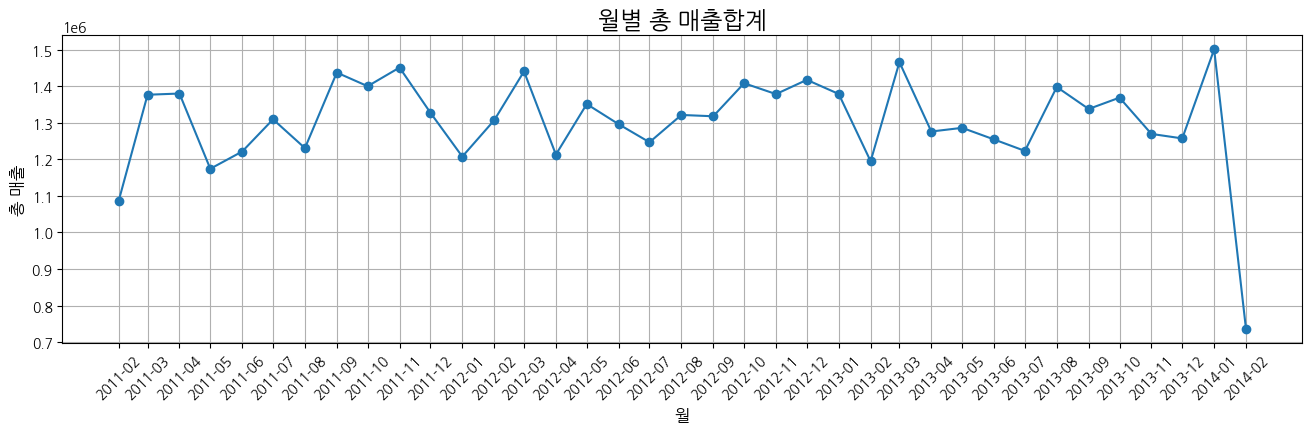

In [28]:
import matplotlib.pyplot as plt

# 시간에 따른 매출 금액 시각화
plt.figure(figsize=(16, 4))
plt.plot(total_df.index, total_df['total_amt'], marker='o')
plt.title('월별 총 매출합계', fontsize=17)
plt.xlabel('월', fontsize=12)
plt.ylabel('총 매출', fontsize=12)
plt.xticks(total_df.index, [x.strftime('%Y-%m') for x in total_df.index],rotation=45)
plt.grid(True)
plt.show()

2014년 2월 매출이 2014년 1월매출에 비해 50%가까이 떨어진 것을 알 수 있다.

## 오프라인 온라인 판매 채널

In [29]:
# 대 카테고리별 월별 데이터 합계
big_df = join_df.groupby(['prod_cat', 'tran_month'])['total_amt'].sum().unstack(fill_value=0).T

# 온라인 오프라인 컬럼
# 'Store_type' 컬럼의 값이 'Flagship store'인 경우에는 'offline' 값, 그렇지 않은 경우에는 'online' 값 설정
join_df['on_off'] = join_df['Store_type'].apply(lambda x: 'offline' if x == 'Flagship store' else 'online')

# 대 카테고리별 판매채널 구매 데이터 합계
on_off_df = join_df.groupby(['prod_cat', 'on_off','tran_month'])['total_amt'].count().unstack(fill_value=0).T

### 파이차트 시각화

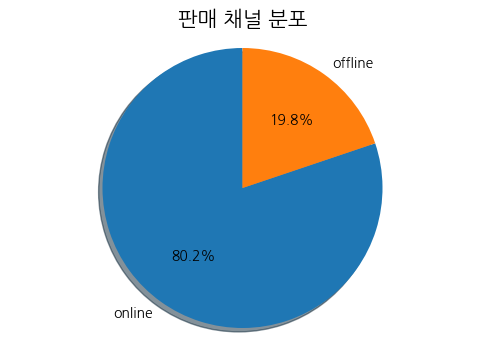

In [30]:
# 'on_off' 열 값의 카운트 계산
on_off_counts = join_df['on_off'].value_counts()

# 파이 차트 그리기
plt.figure(figsize=(6, 4))
plt.pie(on_off_counts, labels=on_off_counts.index, autopct='%1.1f%%', startangle=90, shadow= True)
plt.title('판매 채널 분포', fontsize=15)
plt.axis('equal')  # 원형을 유지하기 위해 설정
plt.show()

In [31]:
a = on_off_df.sum(axis=0)
b = on_off_df.sum(axis=0).groupby(['prod_cat']).sum()
(a/b * 100).round(2).T

prod_cat          on_off 
Bags              offline    19.43
                  online     80.57
Books             offline    20.14
                  online     79.86
Clothing          offline    19.68
                  online     80.32
Electronics       offline    20.31
                  online     79.69
Footwear          offline    19.15
                  online     80.85
Home and kitchen  offline    19.59
                  online     80.41
dtype: float64

### 카테고리별 온라인 판매 횟수와과 매출 선그래프

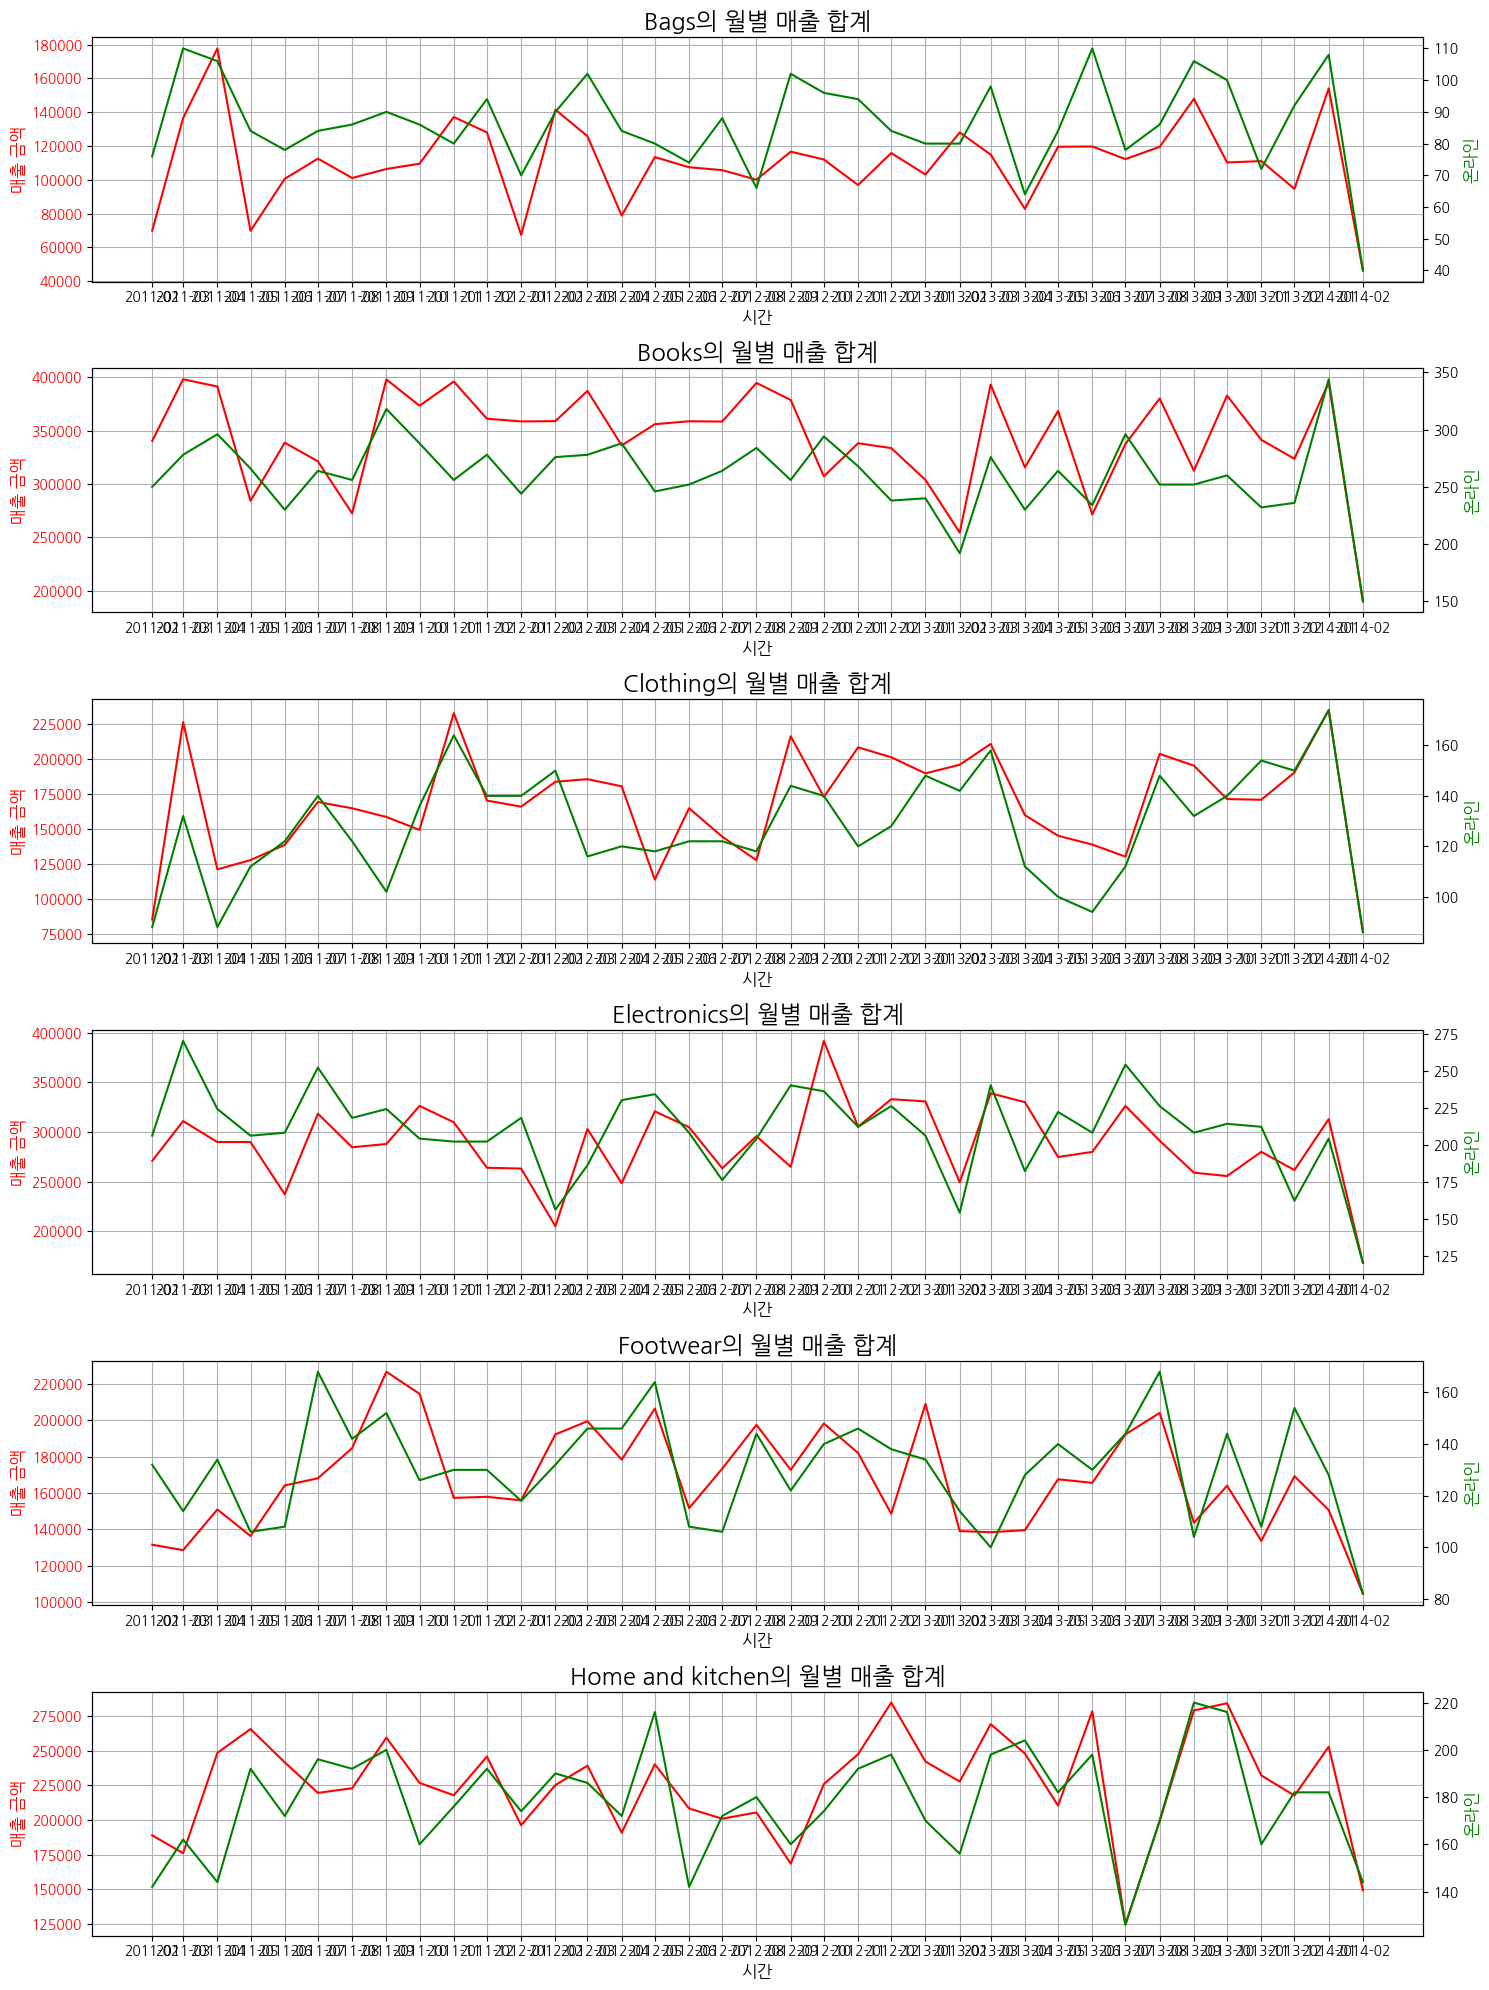

In [32]:
# 시간에 따른 카테고리별 매출 금액 시각화하기
fig, ax1 = plt.subplots(len(big_df.columns), 1, figsize=(15, 20))  # 전체 그래프의 크기 설정
for count, column in enumerate(big_df.columns, start=0):
    ax1[count].plot(big_df[column].index, big_df[column].values,color='r')
    ax1[count].set_title(f'{column}의 월별 매출 합계', fontsize=17)
    ax1[count].set_xlabel('시간', fontsize=12)
    ax1[count].set_ylabel('매출 금액', fontsize=12, color='r')
    ax1[count].tick_params(axis='y', labelcolor='r')
    ax1[count].grid(True)

    # 두 번째 두 번째 축 (판매 채널 2)
    ax3 = ax1[count].twinx()
    ax3.plot(on_off_df[column]['online'].index, on_off_df[column]['online'].values * 2, color='g')
    ax3.set_ylabel('온라인', fontsize=12, color='g')

    # 각 축을 따로 설정해줘야 함
    ax3.yaxis.label.set_color('g')

    # x축 라벨 설정
    plt.xticks(big_df.index, [x.strftime('%Y-%m') for x in big_df.index], rotation=45)
plt.tight_layout()
plt.show()


In [33]:
# 서브 카테고리별 월별 데이터로 합계
sub_df = join_df.groupby(['category_name', 'tran_month']).sum()['total_amt'].unstack(fill_value=0).T

# 온라인 오프라인 컬럼
# 'Store_type' 컬럼의 값이 'Flagship store'인 경우에는 'offline' 값, 그렇지 않은 경우에는 'online' 값 설정
join_df['on_off'] = join_df['Store_type'].apply(lambda x: 'offline' if x == 'Flagship store' else 'online')

# 대 카테고리별 판매채널 구매 데이터 합계
on_off_df = join_df.groupby(['category_name', 'on_off','tran_month'])['total_amt'].count().unstack(fill_value=0).T

<ipython-input-33-f3831e8bae71>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sub_df = join_df.groupby(['category_name', 'tran_month']).sum()['total_amt'].unstack(fill_value=0).T


In [34]:
sub_df

category_name  Bags/Mens  Bags/Women  Books/Academic  Books/Children  \
tran_month                                                             
2011-02-01     33338.955   36563.345       41764.580       55384.810   
2011-03-01     69651.465   66902.225       66711.060       55985.930   
2011-04-01     86893.885   90897.300       51870.910       56466.605   
2011-05-01     53539.460   16256.760       41153.515       58780.475   
2011-06-01     57778.240   42849.690       65418.210       82595.435   
2011-07-01     55760.510   56788.160       59864.480       37815.310   
2011-08-01     54849.990   46251.985       43713.800       80144.545   
2011-09-01     57226.845   49184.655       68123.250       69308.915   
2011-10-01     70518.890   39015.340       29743.285       67284.555   
2011-11-01     82526.925   54645.565       81328.000       56557.215   
2011-12-01     42901.625   85197.710       51372.555       71083.545   
2012-01-01     26237.120   41163.460       56616.885       84060.665   
2012-02-01     88185.630   53339.455       29506.815       74578.660   
2012-03-01     77500.280   48351.485       58782.685       85386.665   
2012-04-01     39152.360   39678.340       55169.335       60237.970   
2012-05-01     38470.575   74988.615       70808.400       51833.340   
2012-06-01     59317.505   48134.905       61015.890       66081.210   
2012-07-01     37252.865   68479.060       41938.065       79943.435   
2012-08-01     47277.425   52796.900       61951.825       47008.910   
2012-09-01     39950.170   76713.520       66891.175       87175.660   
2012-10-01     46050.875   65976.235       28118.935       57252.260   
2012-11-01     48526.075   48379.110       59714.200       63610.430   
2012-12-01     83555.680   32301.360       50953.760       60257.860   
2013-01-01     42306.030   60831.355       52699.660       43900.545   
2013-02-01     65843.635   62213.710       28986.360       32364.345   
2013-03-01     52464.295   62485.540       53314.040       94793.530   
2013-04-01     35596.470   47190.130       77059.385       25177.425   
2013-05-01     76004.110   43569.045       53248.845       59100.925   
2013-06-01     40568.970   79161.095       52672.035       38395.435   
2013-07-01     60703.175   51561.510       51297.415       33512.440   
2013-08-01     71804.005   47718.320       69585.165       58363.890   
2013-09-01     71280.235   76675.950       64252.435       55262.155   
2013-10-01     64859.080   45406.660       83225.285       69792.905   
2013-11-01     59671.105   51412.335       59924.150       46266.350   
2013-12-01     53911.845   40744.665       53753.830       34536.775   
2014-01-01     99514.090   54622.360       56135.105       62812.620   
2014-02-01     28136.615   18208.190       38447.370       28531.100   

category_name  Books/Comics  Books/DIY  Books/Fiction  Books/Non-Fiction  \
tran_month                                                                 
2011-02-01        42372.330  67155.270      60877.765          72756.515   
2011-03-01        56542.850  54511.860      80346.760          84010.940   
2011-04-01        75212.930  49779.145      91661.960          66327.625   
2011-05-01        51171.445  46901.725      53392.495          32888.115   
2011-06-01        38003.160  64388.350      41870.660          46416.630   
2011-07-01        76680.370  49601.240      44383.430          52883.090   
2011-08-01        53148.290  33923.500      37888.240          23622.690   
2011-09-01        85455.175  32730.100      51189.125          91162.500   
2011-10-01        89676.275  52025.610      62456.810          72105.670   
2011-11-01        61052.355  66217.125      67009.410          63828.115   
2011-12-01        53299.675  69862.520      58391.515          57132.920   
2012-01-01        30696.900  39014.235      86611.005          61618.115   
2012-02-01        84008.730  48121.645      59499.830          63159.590   
2012-03-01        48865.310  59547.345      56962.7

In [35]:
a = on_off_df.sum(axis=0)
b = on_off_df.sum(axis=0).groupby(['category_name']).sum()
(a/b * 100).round(2)

category_name                    on_off 
Bags/Mens                        offline    19.30
                                 online     80.70
Bags/Women                       offline    19.55
                                 online     80.45
Books/Academic                   offline    19.27
                                 online     80.73
Books/Children                   offline    22.59
                                 online     77.41
Books/Comics                     offline    18.57
                                 online     81.43
Books/DIY                        offline    19.11
                                 online     80.89
Books/Fiction                    offline    19.54
                                 online     80.46
Books/Non-Fiction                offline    21.73
                                 online     78.27
Clothing/Kids                    offline    18.90
                                 online     81.10
Clothing/Mens                    offline    20.17
         

## 서브 카테고리별 월별 매출 합계 그래프

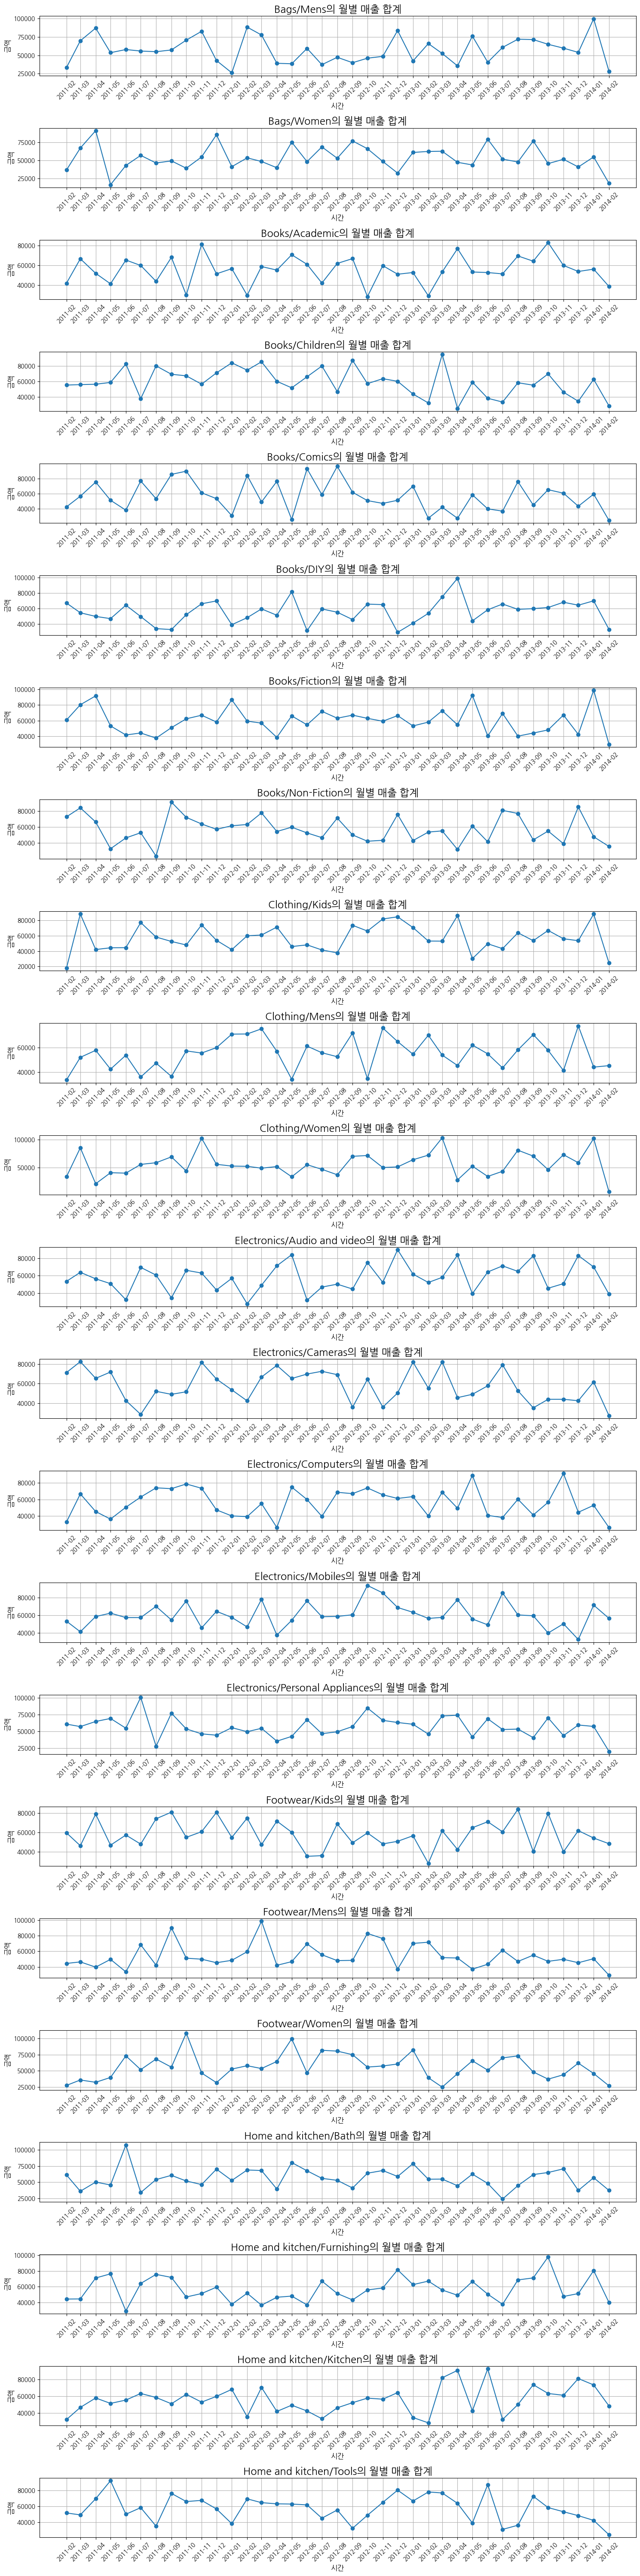

In [36]:
# 시간에 따른 카테고리별 매출 금액 시각화하기
count = 0
plt.figure(figsize=(15, 60))  # 전체 그래프의 크기 설정
for column in sub_df.columns:
    count += 1
    plt.subplot(len(sub_df.columns), 1, count)  # 서브플롯 생성
    plt.plot(sub_df[column].index, sub_df[column].values, marker='o')
    plt.title(f'{column}의 월별 매출 합계', fontsize=17)
    plt.xlabel('시간', fontsize=12)
    plt.ylabel('금액', fontsize=12)
    plt.xticks(sub_df[column].index, [x.strftime('%Y-%m') for x in sub_df[column].index], rotation=45)
    plt.grid(True)

plt.tight_layout()
plt.show()


## 판매체널에 따른 판매횟수 시각화

In [37]:
# 구매방법에 따른 월별 합계 파악
store_df = join_df.groupby(['Store_type', 'tran_month']).count()['total_amt'].unstack(fill_value=0).T

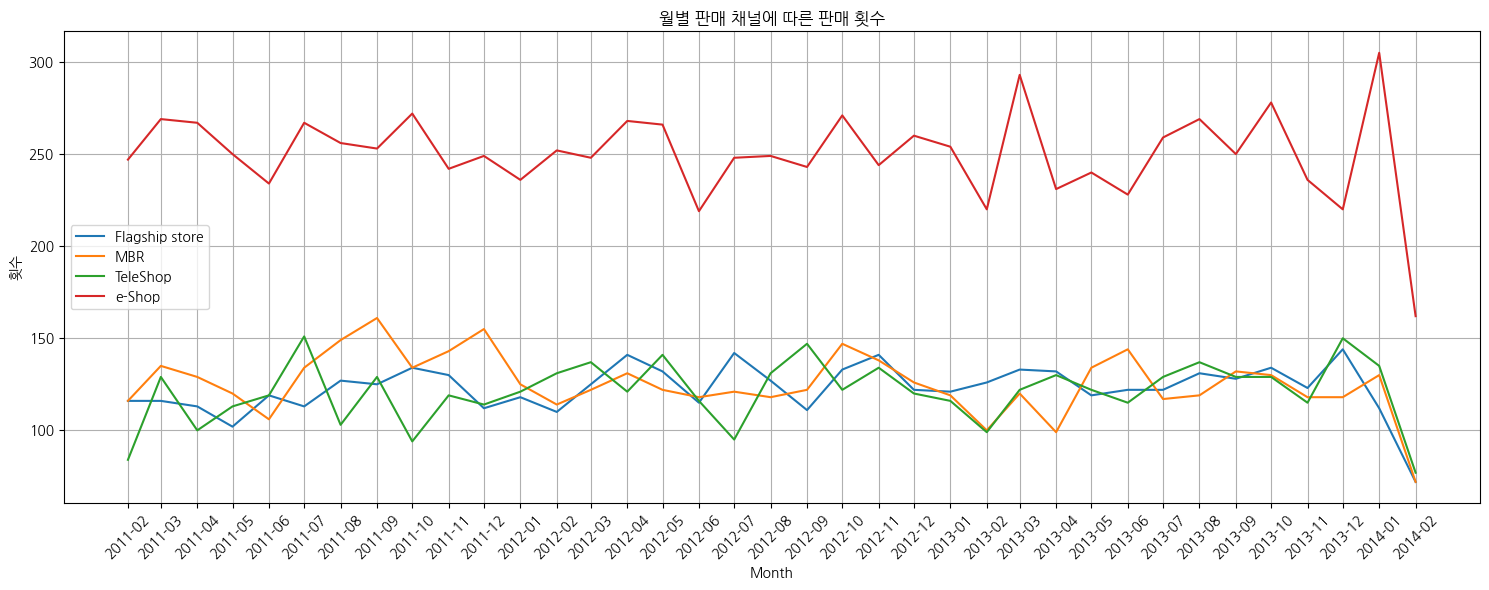

In [38]:
# 한 그림에 각 구매방법에 따른 그래프 그리기
plt.figure(figsize=(15, 6))
for store_type in store_df.columns:
    plt.plot(store_df.index, store_df[store_type], label=store_type)

plt.title('월별 판매 채널에 따른 판매 횟수')
plt.xlabel('Month')
plt.ylabel('횟수')
plt.xticks(store_df.index, [x.strftime('%Y-%m') for x in store_df.index], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 온라인 오프라인으로 시각화

<ipython-input-39-44f43763a321>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  on_off_group = join_df.groupby(['on_off', 'tran_month']).sum()['total_amt'].unstack(fill_value=0).T


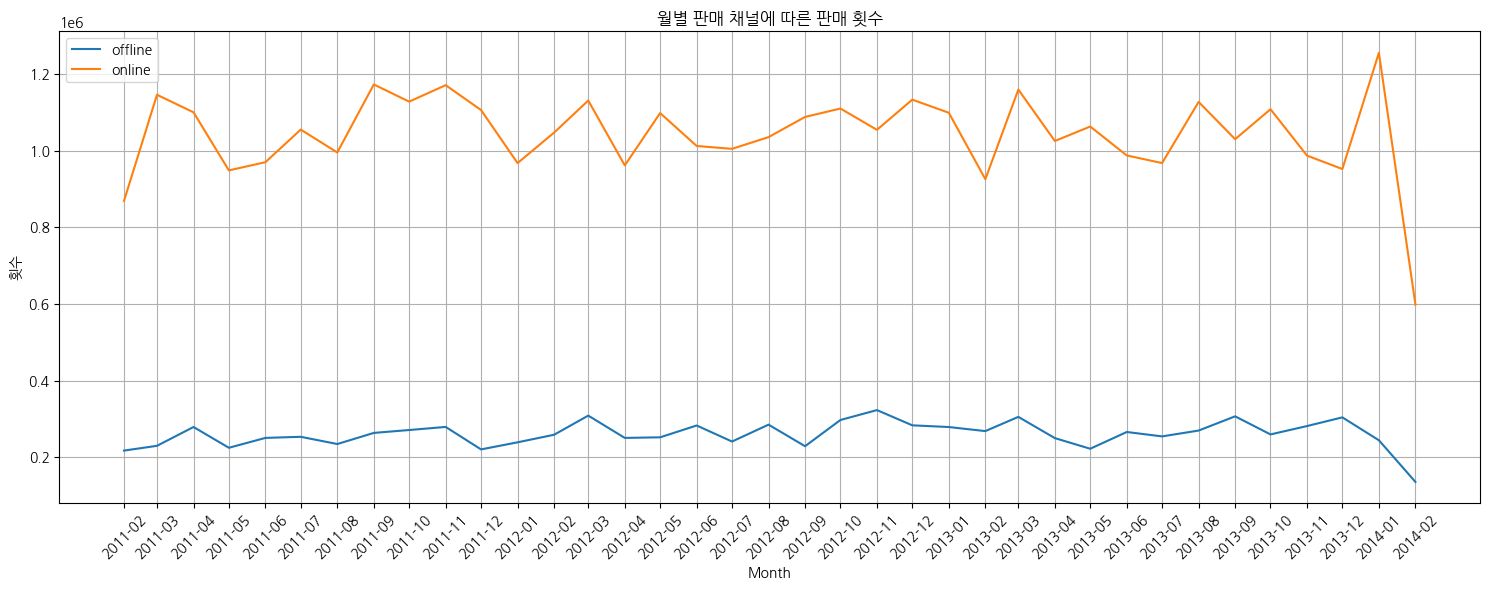

In [39]:
on_off_group = join_df.groupby(['on_off', 'tran_month']).sum()['total_amt'].unstack(fill_value=0).T

# 한 그림에 각 구매방법에 따른 그래프 그리기
plt.figure(figsize=(15, 6))
for store_type in on_off_group.columns:
    plt.plot(on_off_group.index, on_off_group[store_type], label=store_type)

plt.title('월별 판매 채널에 따른 판매 횟수')
plt.xlabel('Month')
plt.ylabel('횟수')
plt.xticks(on_off_group.index, [x.strftime('%Y-%m') for x in on_off_group.index], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
big_sum_df = big_df.sum(axis=1)

### 이중축으로 매출 총합도 시각화

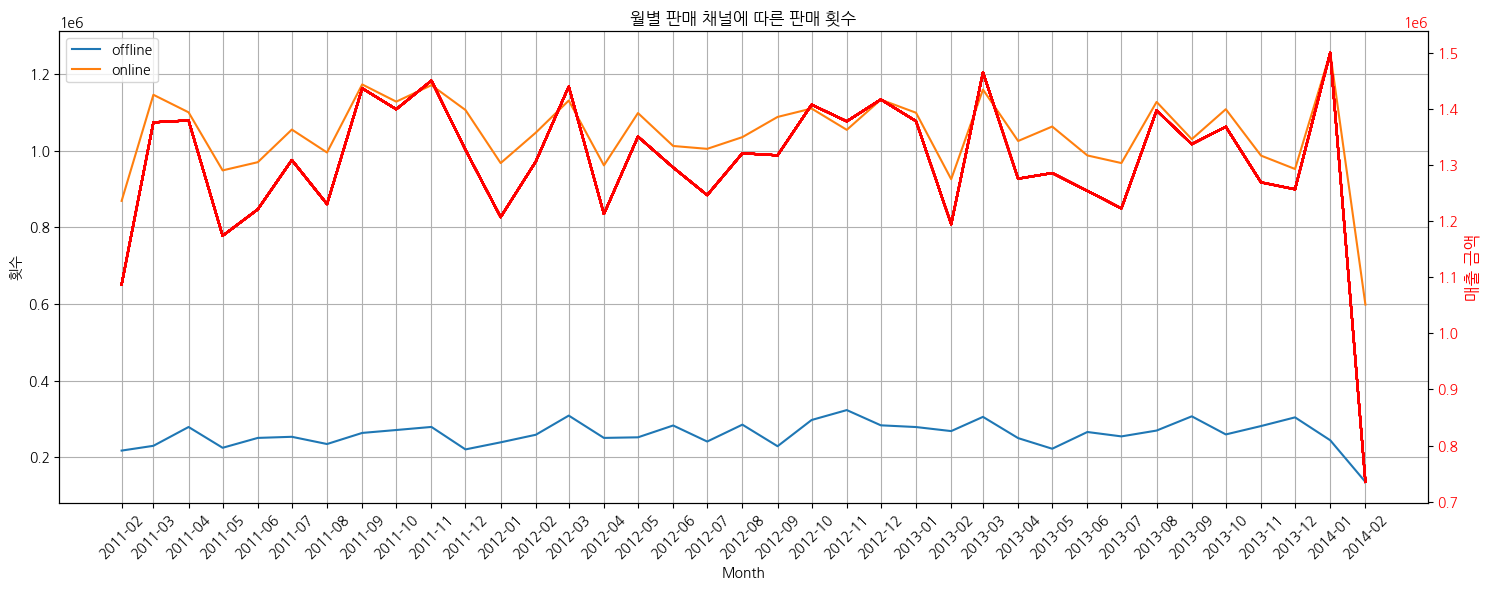

In [41]:
# 월별 총 매출액
big_sum_df = big_df.sum(axis=1)

# 판매 채널에 따른 월별 판매 횟수 그래프
plt.figure(figsize=(15, 6))
for store_type in on_off_group.columns:
    plt.plot(on_off_group.index, on_off_group[store_type], label=store_type)

plt.title('월별 판매 채널에 따른 판매 횟수')
plt.xlabel('Month')
plt.ylabel('횟수')
plt.xticks(on_off_group.index, [x.strftime('%Y-%m') for x in on_off_group.index], rotation=45)
plt.legend()
plt.grid(True)

# 이중 축을 사용하여 판매 채널에 따른 월별 매출 합계 그래프 그리기
ax1 = plt.gca().twinx()  # 이중 축 설정
for count, column in enumerate(big_sum_df, start=0):
    ax1.plot(big_sum_df.index, big_sum_df.values, color='r', linestyle='-', label=f'{column} 매출')
    ax1.set_ylabel('매출 금액', fontsize=12, color='r')
    ax1.tick_params(axis='y', labelcolor='r')

plt.tight_layout()
plt.show()


## 온라인과 오프라인의 환불 발생률 시각화

In [42]:
# 음수를 양수로 변환하는 함수 정의
def neg_to_pos(value, _):
    return int(abs(value))

In [43]:
online_df = join_df[join_df['on_off']=='online']
offline_df = join_df[join_df['on_off']=='offline']

 # 판매채널별 월별 환불 데이터 합계
refund_online_df = online_df[online_df['Qty'] < 0].groupby(['prod_cat', 'tran_month']).sum()['Qty'].unstack(fill_value=0).T
refund_offline_df = offline_df[offline_df['Qty'] < 0].groupby(['prod_cat', 'tran_month']).sum()['Qty'].unstack(fill_value=0).T

# 판매채널별 월별 환불데이터 합계
qty_online_df = online_df.groupby(['prod_cat', 'tran_month']).sum()['Qty'].unstack(fill_value=0).T
qty_offline_df = offline_df.groupby(['prod_cat', 'tran_month']).sum()['Qty'].unstack(fill_value=0).T

# 판매채널별 주문 수량에 따른 환불 비율 데이터프레임
per_refund_online_df = refund_online_df / qty_online_df * 100
per_refund_offline_df = refund_offline_df / qty_offline_df * 100
per_refund_online = -per_refund_online_df.mean(axis=0).mean()
per_refund_offline = -per_refund_offline_df.mean(axis=0).mean()

per_list = [per_refund_online, per_refund_offline]

<ipython-input-43-0ef0c026bf20>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  refund_online_df = online_df[online_df['Qty'] < 0].groupby(['prod_cat', 'tran_month']).sum()['Qty'].unstack(fill_value=0).T
<ipython-input-43-0ef0c026bf20>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  refund_offline_df = offline_df[offline_df['Qty'] < 0].groupby(['prod_cat', 'tran_month']).sum()['Qty'].unstack(fill_value=0).T
<ipython-input-43-0ef0c026bf20>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_

In [44]:
per_refund_online_df.head()

prod_cat         Bags      Books   Clothing  Electronics   Footwear  \
tran_month                                                            
2011-02-01 -34.246575  -8.777429  -9.523810    -9.615385 -40.186916   
2011-03-01 -10.000000  -5.305040  -8.982036   -16.242038  -5.263158   
2011-04-01  -9.285714 -11.904762 -10.924370   -12.903226 -10.000000   
2011-05-01 -22.352941 -17.515924  -4.794521    -9.540636 -11.475410   
2011-06-01 -28.571429 -10.526316  -7.586207    -9.638554  -1.923077   

prod_cat    Home and kitchen  
tran_month                    
2011-02-01        -16.770186  
2011-03-01        -30.215827  
2011-04-01         -2.702703  
2011-05-01        -12.863071  
2011-06-01         -5.128205

In [45]:
on_off_total = pd.DataFrame(-per_refund_online_df.mean(axis=0).round(2).values)
on_off_total.rename(columns={0: 'online'}, inplace=True)
on_off_total['offline'] = -per_refund_offline_df.mean(axis=0).round(2).values
on_off_total.index =per_refund_online_df.mean(axis=0).index
on_off_total

online  offline
prod_cat                         
Bags               15.06    12.51
Books              11.66    14.78
Clothing           13.14    15.12
Electronics        10.08    12.69
Footwear           12.19    13.60
Home and kitchen   13.91    11.95

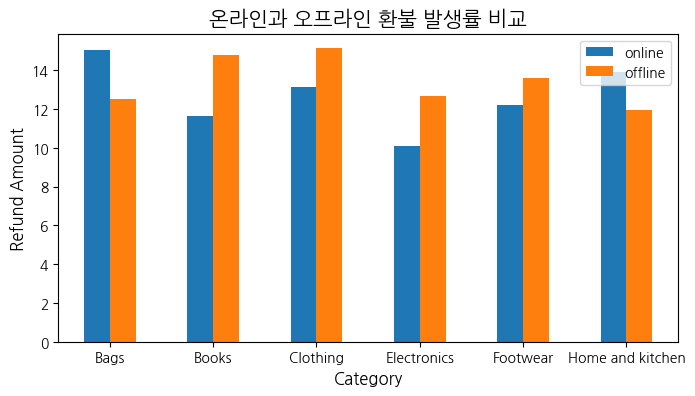

In [46]:
import matplotlib.pyplot as plt

# 막대 그래프 그리기
on_off_total.plot(kind='bar', figsize=(8, 4))

# 그래프 제목과 라벨 설정
plt.title('온라인과 오프라인 환불 발생률 비교', fontsize=15)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Refund Amount', fontsize=12)

# x축 라벨 설정
plt.xticks(rotation=0)

# 범례 표시
plt.legend()

# 그래프 출력
plt.show()

## 온라인과 오프라인 총 환불 비중 시각화

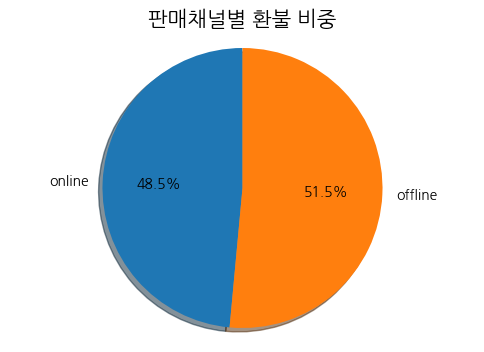

In [47]:
labels = ['online', 'offline']
# 파이 차트 그리기
plt.figure(figsize=(6, 4))
plt.pie(per_list, labels=labels, autopct='%1.1f%%', startangle=90, shadow= True)
plt.title('판매채널별 환불 비중', fontsize=15)
plt.axis('equal')  # 원형을 유지하기 위해 설정
plt.show()

## 월별 환불율 시각화하기

In [48]:
 # 대 카테고리별 월별 환불 데이터 합계
refund_big_df = join_df[join_df['Qty'] < 0].groupby(['prod_cat', 'tran_month']).sum()['Qty'].unstack(fill_value=0).T

# 대 카테고리별 월별 환불데이터 합계
qty_big_df = join_df.groupby(['prod_cat', 'tran_month']).sum()['Qty'].unstack(fill_value=0).T

<ipython-input-48-a86b98ffe33a>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  refund_big_df = join_df[join_df['Qty'] < 0].groupby(['prod_cat', 'tran_month']).sum()['Qty'].unstack(fill_value=0).T
<ipython-input-48-a86b98ffe33a>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  qty_big_df = join_df.groupby(['prod_cat', 'tran_month']).sum()['Qty'].unstack(fill_value=0).T


In [49]:
# 카테고리별 주문 수량에 따른 환불 비율 데이터프레임
per_refund_big_df = refund_big_df / qty_big_df * 100

In [50]:
# 총 환불 데이터 프레임 만들기
refund_total2_df = per_refund_big_df.groupby('tran_month').sum()
refund_total_df = refund_total2_df.mean(axis=1)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


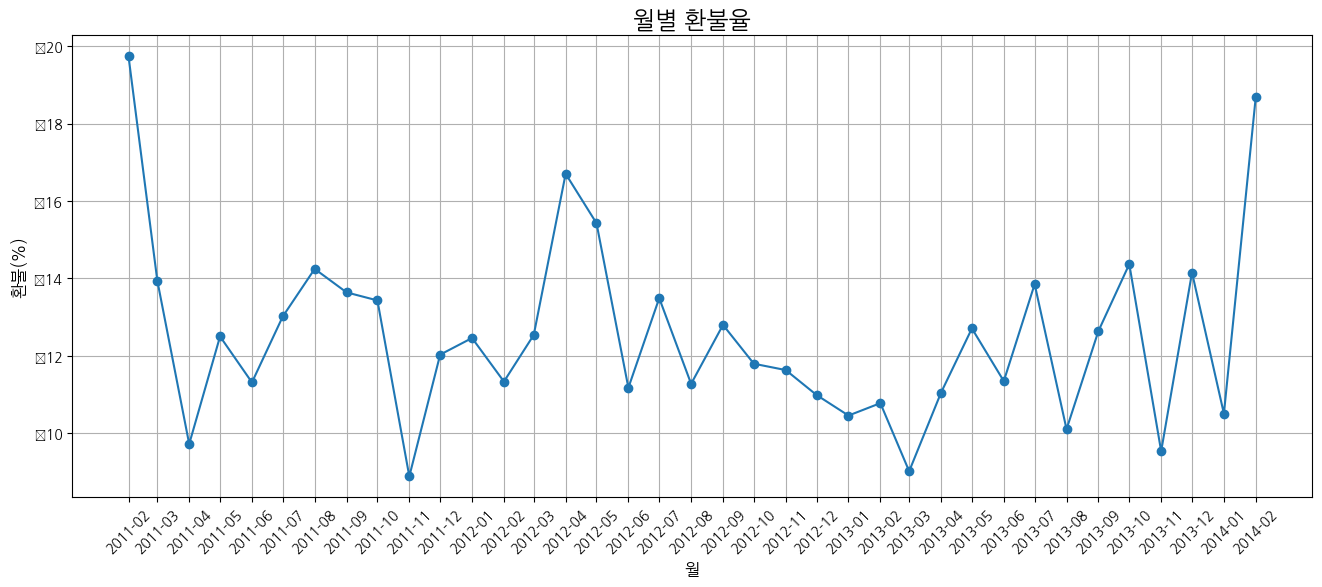

In [51]:
import matplotlib.pyplot as plt

# 시간에 따른 매출 금액 시각화
plt.figure(figsize=(16, 6))
plt.plot(refund_total_df.index, refund_total_df.values, marker='o')
plt.title('월별 환불율', fontsize=17)
plt.xlabel('월', fontsize=12)
plt.ylabel('환불(%)', fontsize=12)
plt.xticks(refund_total_df.index, [x.strftime('%Y-%m') for x in refund_total_df.index],rotation=45)
plt.grid(True)
plt.gca().invert_yaxis()

plt.show()

### 이중축으로 매출 포함

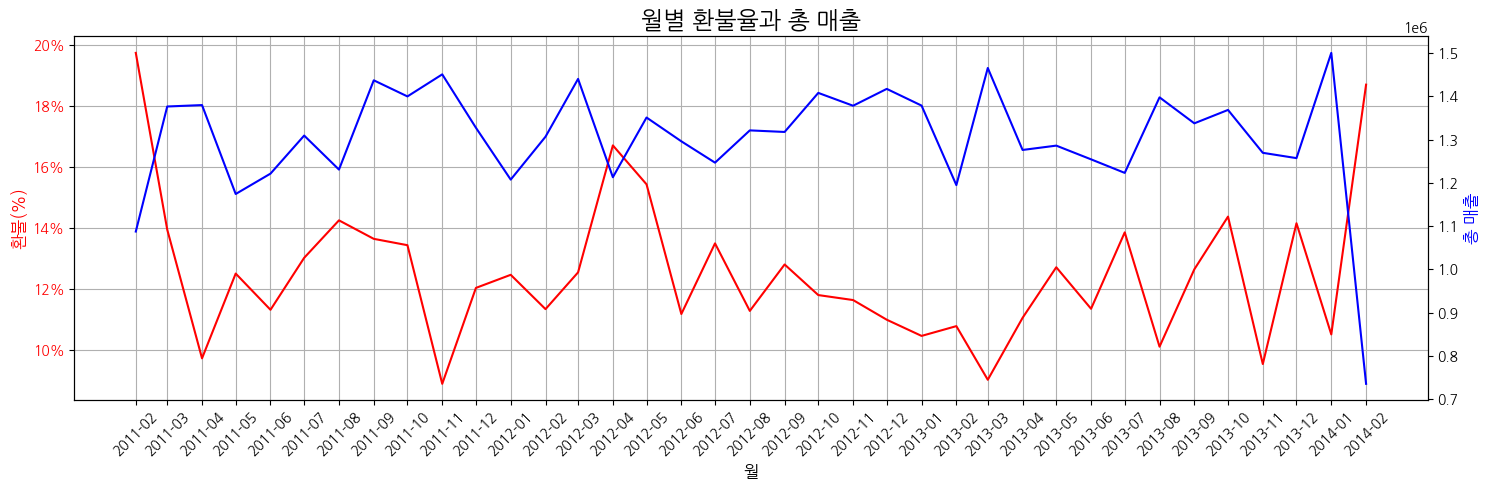

In [52]:
import matplotlib.ticker as ticker

# 그래프 생성
fig, ax1 = plt.subplots(figsize=(15, 5))

# 환불율 시각화
ax1.plot(refund_total_df.index, -refund_total_df.values, color='r')
ax1.set_title('월별 환불율과 총 매출', fontsize=17)
ax1.set_xlabel('월', fontsize=12)
ax1.set_ylabel('환불(%)', fontsize=12, color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.grid(True)
# 두 번째 축 (총 매출)
ax2 = ax1.twinx()
ax2.plot(total_df.index, total_df['total_amt'], color='b')
ax2.set_ylabel('총 매출', fontsize=12, color='b')
ax2.yaxis.label.set_color('b')

# x축 라벨 설정
ax1.set_xticks(total_df.index)
ax1.set_xticklabels([x.strftime('%Y-%m') for x in total_df.index], rotation=45)

# y축 라벨에 음수 기호 추가
formatter = ticker.FuncFormatter(lambda x, _: f'{abs(int(x))}%')  # 절대값과 % 추가
ax1.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()


## 카테고리별 환불 비율 시각화

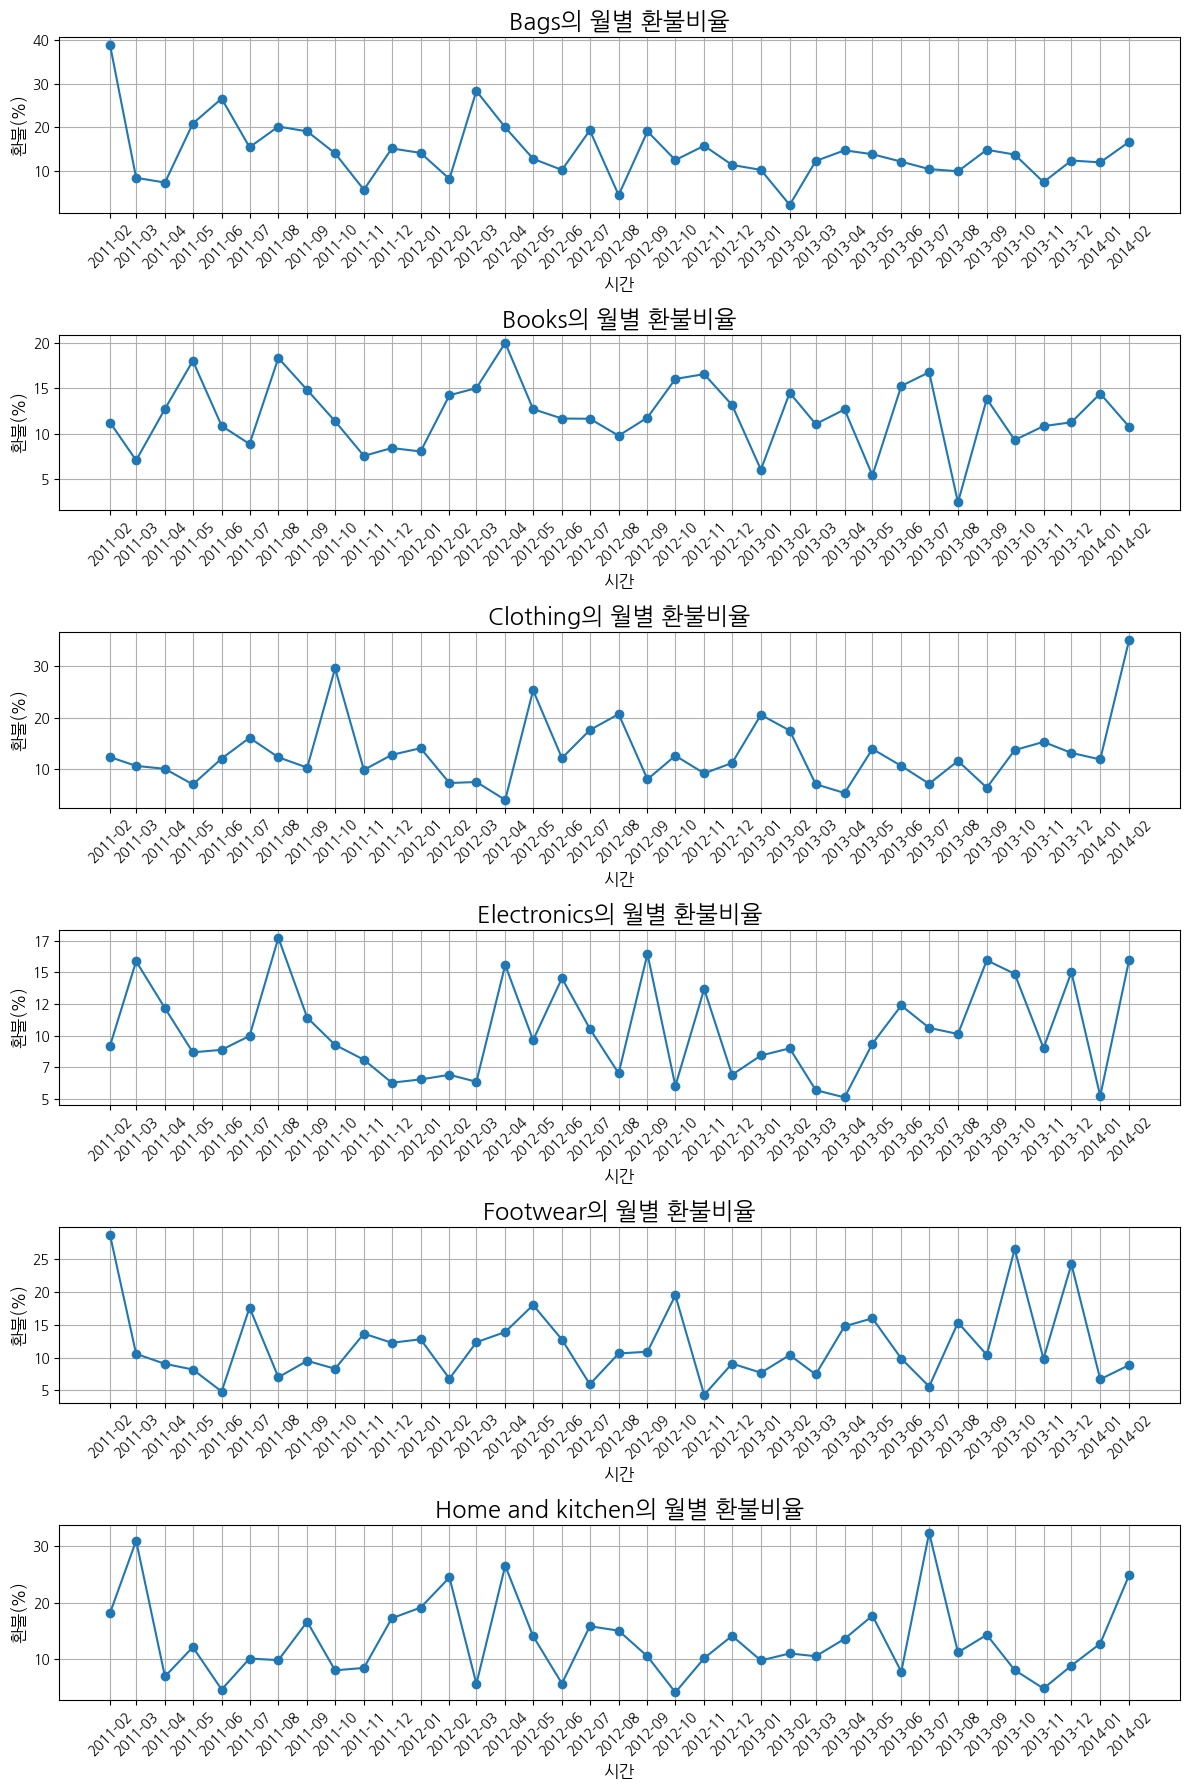

In [53]:
from matplotlib.ticker import FuncFormatter
# 시간에 따른 카테고리별 매출 금액 시각화하기
count = 0
plt.figure(figsize=(12, 18))  # 전체 그래프의 크기 설정
for column in per_refund_big_df.columns:
    count += 1
    plt.subplot(len(per_refund_big_df.columns), 1, count)  # 서브플롯 생성
    plt.plot(per_refund_big_df[column].index, per_refund_big_df[column].values, marker='o')
    plt.title(f'{column}의 월별 환불비율', fontsize=17)
    plt.xlabel('시간', fontsize=12)
    plt.ylabel('환불(%)', fontsize=12)
    plt.xticks(per_refund_big_df[column].index, [x.strftime('%Y-%m') for x in per_refund_big_df[column].index], rotation=45)
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(neg_to_pos))
    plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 이중축으로 매출도 포함

In [54]:
per_refund_big = -per_refund_big_df.mean(axis=0).sort_values()

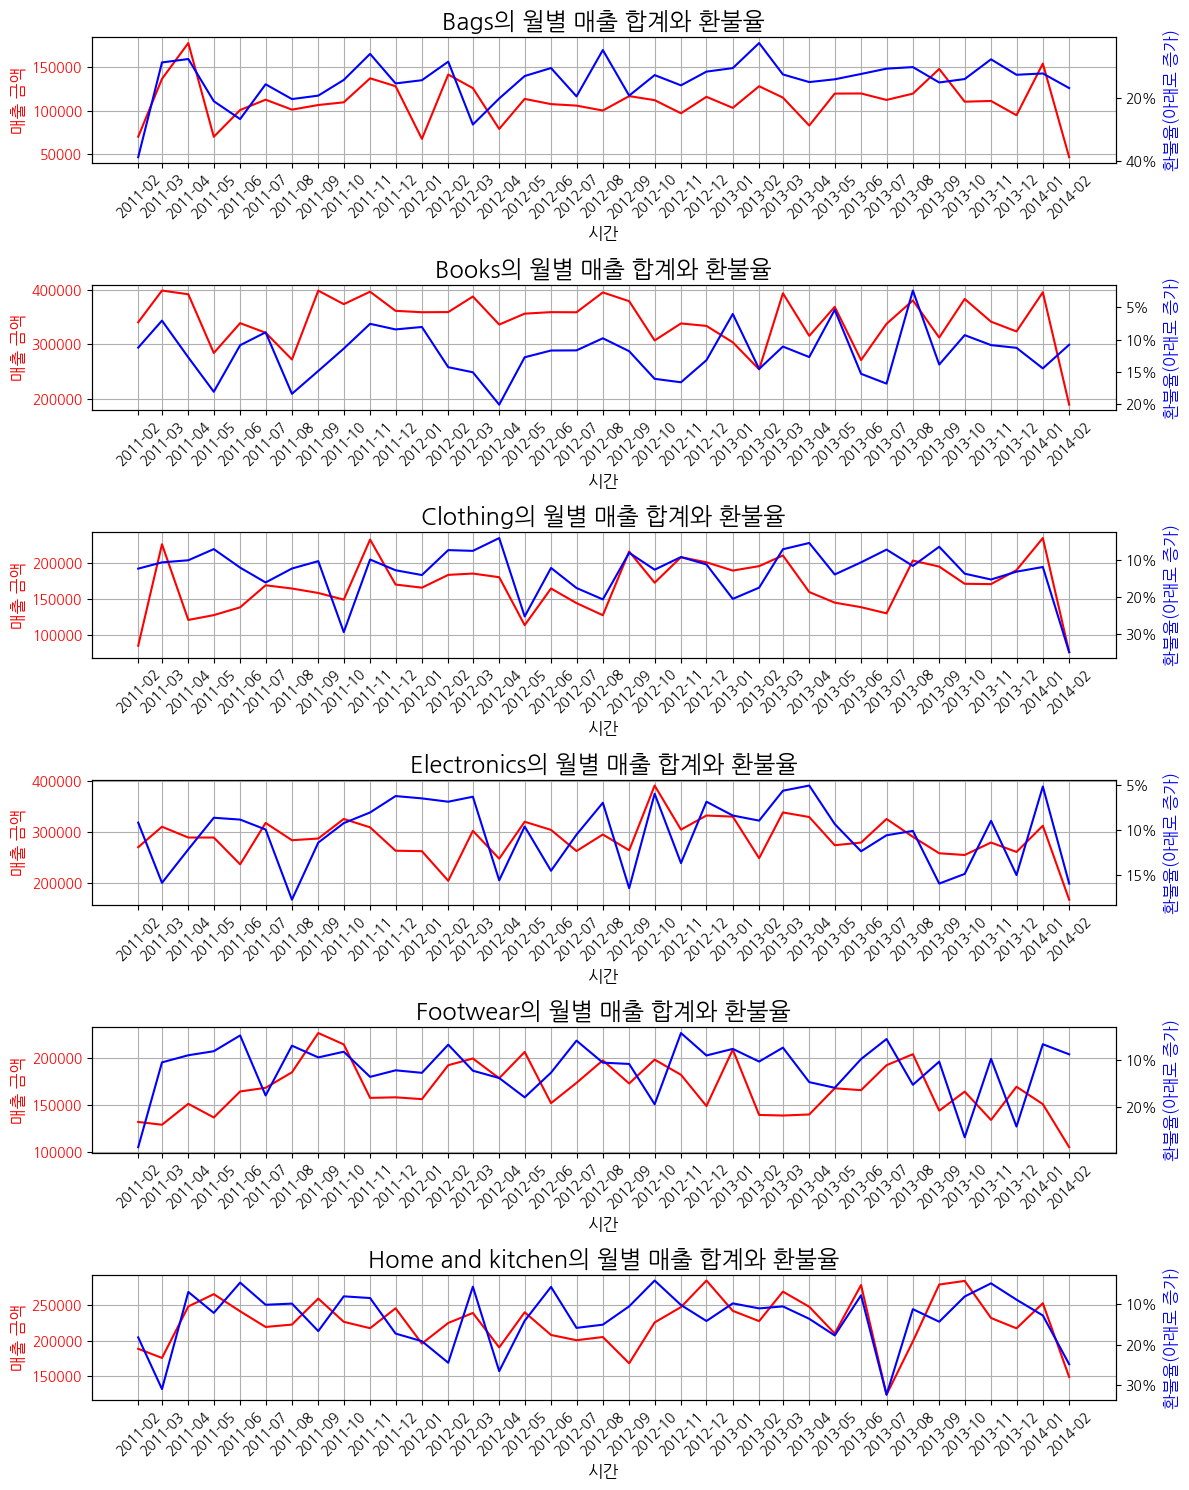

In [55]:
import matplotlib.ticker as ticker

# 시간에 따른 카테고리별 매출과 환불율 시각화하기
fig, ax1 = plt.subplots(len(big_df.columns), 1, figsize=(12, 15))  # 전체 그래프의 크기 설정
for count, column in enumerate(big_df.columns, start=0):
    ax1[count].plot(big_df[column].index, big_df[column].values, color='r')
    ax1[count].set_title(f'{column}의 월별 매출 합계와 환불율', fontsize=17)
    ax1[count].set_xlabel('시간', fontsize=12)
    ax1[count].set_ylabel('매출 금액', fontsize=12, color='r')
    ax1[count].tick_params(axis='y', labelcolor='r')
    ax1[count].grid(True)

    # 첫 번째 두 번째 축 (판매 채널)
    ax2 = ax1[count].twinx()
    ax2.plot(per_refund_big_df[column].index, per_refund_big_df[column].values, color='b')
    ax2.set_ylabel('환불율(아래로 증가)', fontsize=12, color='b')
    # 각 축을 따로 설정해줘야 함
    ax2.yaxis.label.set_color('b')

    # x축 라벨 설정
    ax1[count].set_xticks(big_df.index)
    ax1[count].set_xticklabels([x.strftime('%Y-%m') for x in big_df.index], rotation=45)

    # y축 라벨에 음수 기호 추가
    formatter = ticker.FuncFormatter(lambda x, _: f'{abs(int(x))}%')  # 절대값과 % 추가
    ax2.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()


## 서브 카테고리의 환불율 시각화

In [56]:
# 카테고리별 월별 환불 수량 파악
refund_df = join_df[join_df['Qty'] < 0].groupby(['category_name', 'tran_month']).sum()['Qty'].unstack(fill_value=0).T

# 서브 카테고리별 월별 데이터 합계
qty_df = join_df.groupby(['category_name', 'tran_month']).sum()['Qty'].unstack(fill_value=0).T

# 카테고리별 주문 수량에 따른 환불 비율 데이터프레임
per_refund_df = refund_df / qty_df * 100

<ipython-input-56-2c7230e44e86>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  refund_df = join_df[join_df['Qty'] < 0].groupby(['category_name', 'tran_month']).sum()['Qty'].unstack(fill_value=0).T
<ipython-input-56-2c7230e44e86>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  qty_df = join_df.groupby(['category_name', 'tran_month']).sum()['Qty'].unstack(fill_value=0).T


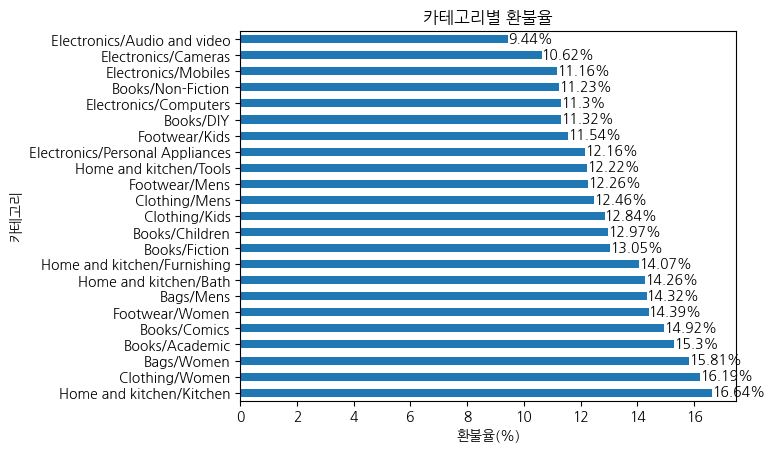

In [57]:
import matplotlib.pyplot as plt

# 각 열의 평균을 계산하고 소수점 둘째 자리에서 반올림
rounded_means = per_refund_df.mean(axis=0).sort_values().round(2)

# 음수 값을 양수로 변환
positive_means = rounded_means.abs()

# 가로 막대 그래프로 표시
ax = positive_means.plot(kind='barh')
plt.title('카테고리별 환불율')
plt.xlabel('환불율(%)')
plt.ylabel('카테고리')

# 각 막대 위에 수치와 % 표시
for i, v in enumerate(positive_means):
    ax.text(v, i, f'{v}%', color='black', ha='left', va='center')

plt.show()

### 월별 환불 수량으로 시각화

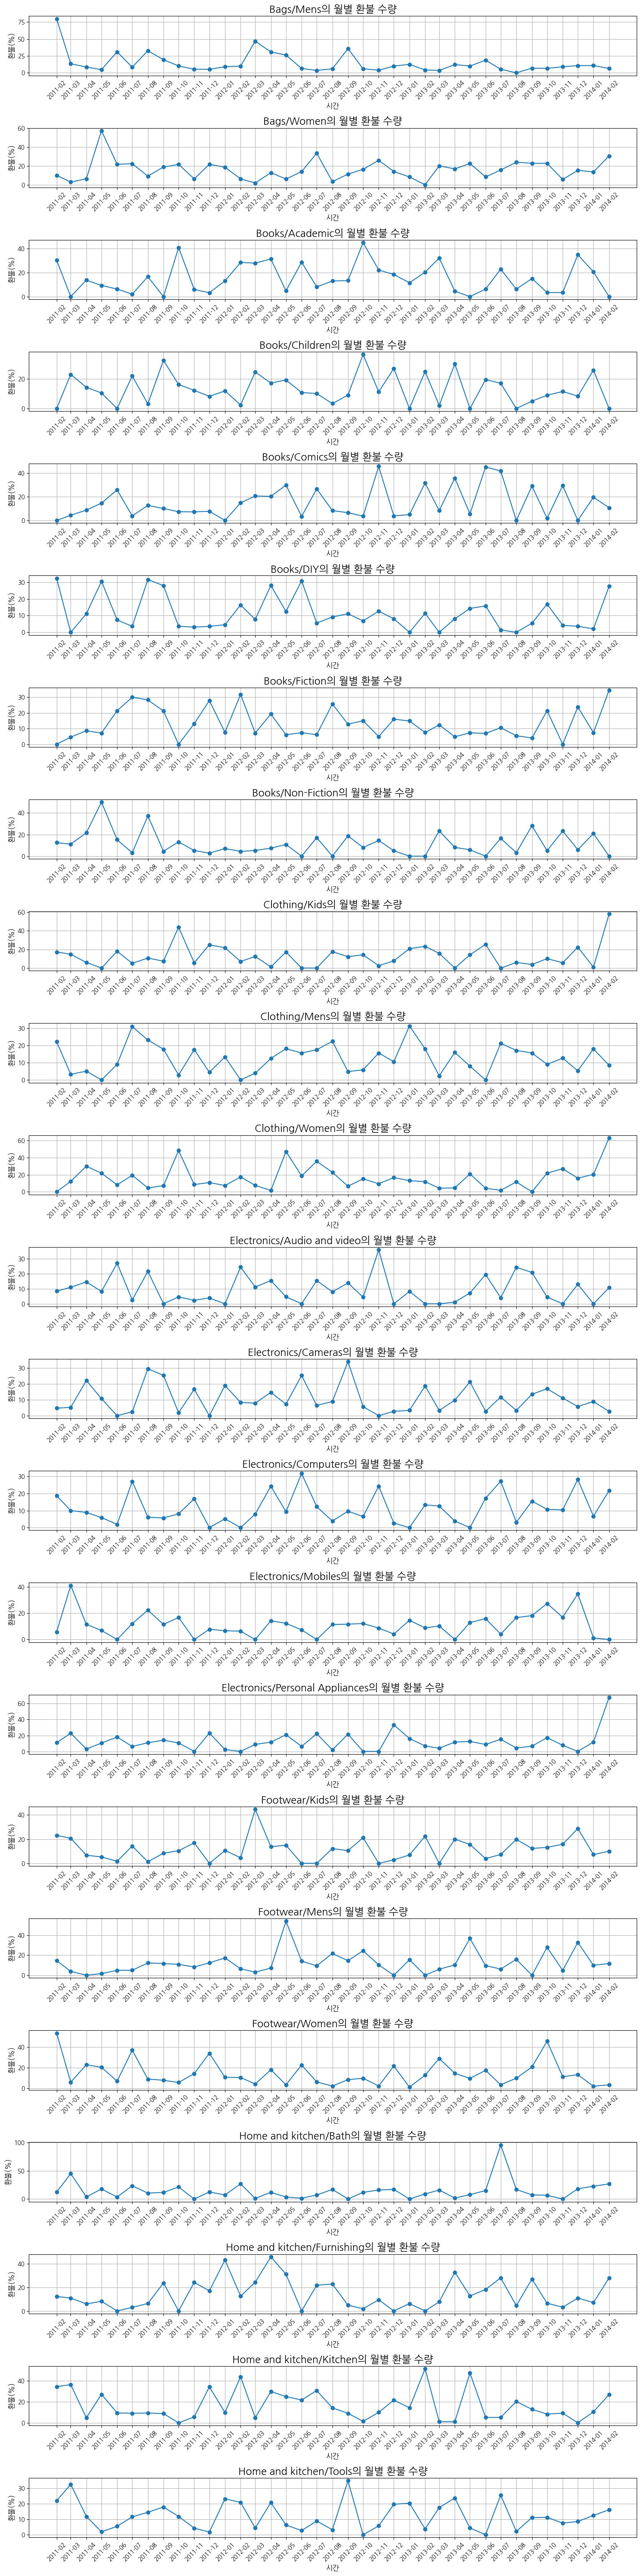

In [58]:
# 시간에 따른 카테고리별 매출 금액 시각화하기
count = 0
plt.figure(figsize=(15, 60))  # 전체 그래프의 크기 설정
for column in per_refund_df.columns:
    count += 1
    plt.subplot(len(per_refund_df.columns), 1, count)  # 서브플롯 생성
    plt.plot(per_refund_df[column].index, per_refund_df[column].values, marker='o')
    plt.title(f'{column}의 월별 환불 수량', fontsize=17)
    plt.xlabel('시간', fontsize=12)
    plt.ylabel('환불(%)', fontsize=12)
    plt.xticks(per_refund_df[column].index, [x.strftime('%Y-%m') for x in per_refund_df[column].index], rotation=45)
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(neg_to_pos))
    plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 환불율이 15%  넘는 카테고리는 매출과 함께 비교

In [59]:
# 카테고리별 평균 환불율 만들기
per15_refund_df = per_refund_df.mean(axis=0).sort_values().round(2)
per15_refund_df = -per15_refund_df[per15_refund_df.values <= -15]
per15_refund_df

category_name
Home and kitchen/Kitchen    16.64
Clothing/Women              16.19
Bags/Women                  15.81
Books/Academic              15.30
dtype: float64

In [60]:
sub15_df = sub_df[per15_refund_df.index]

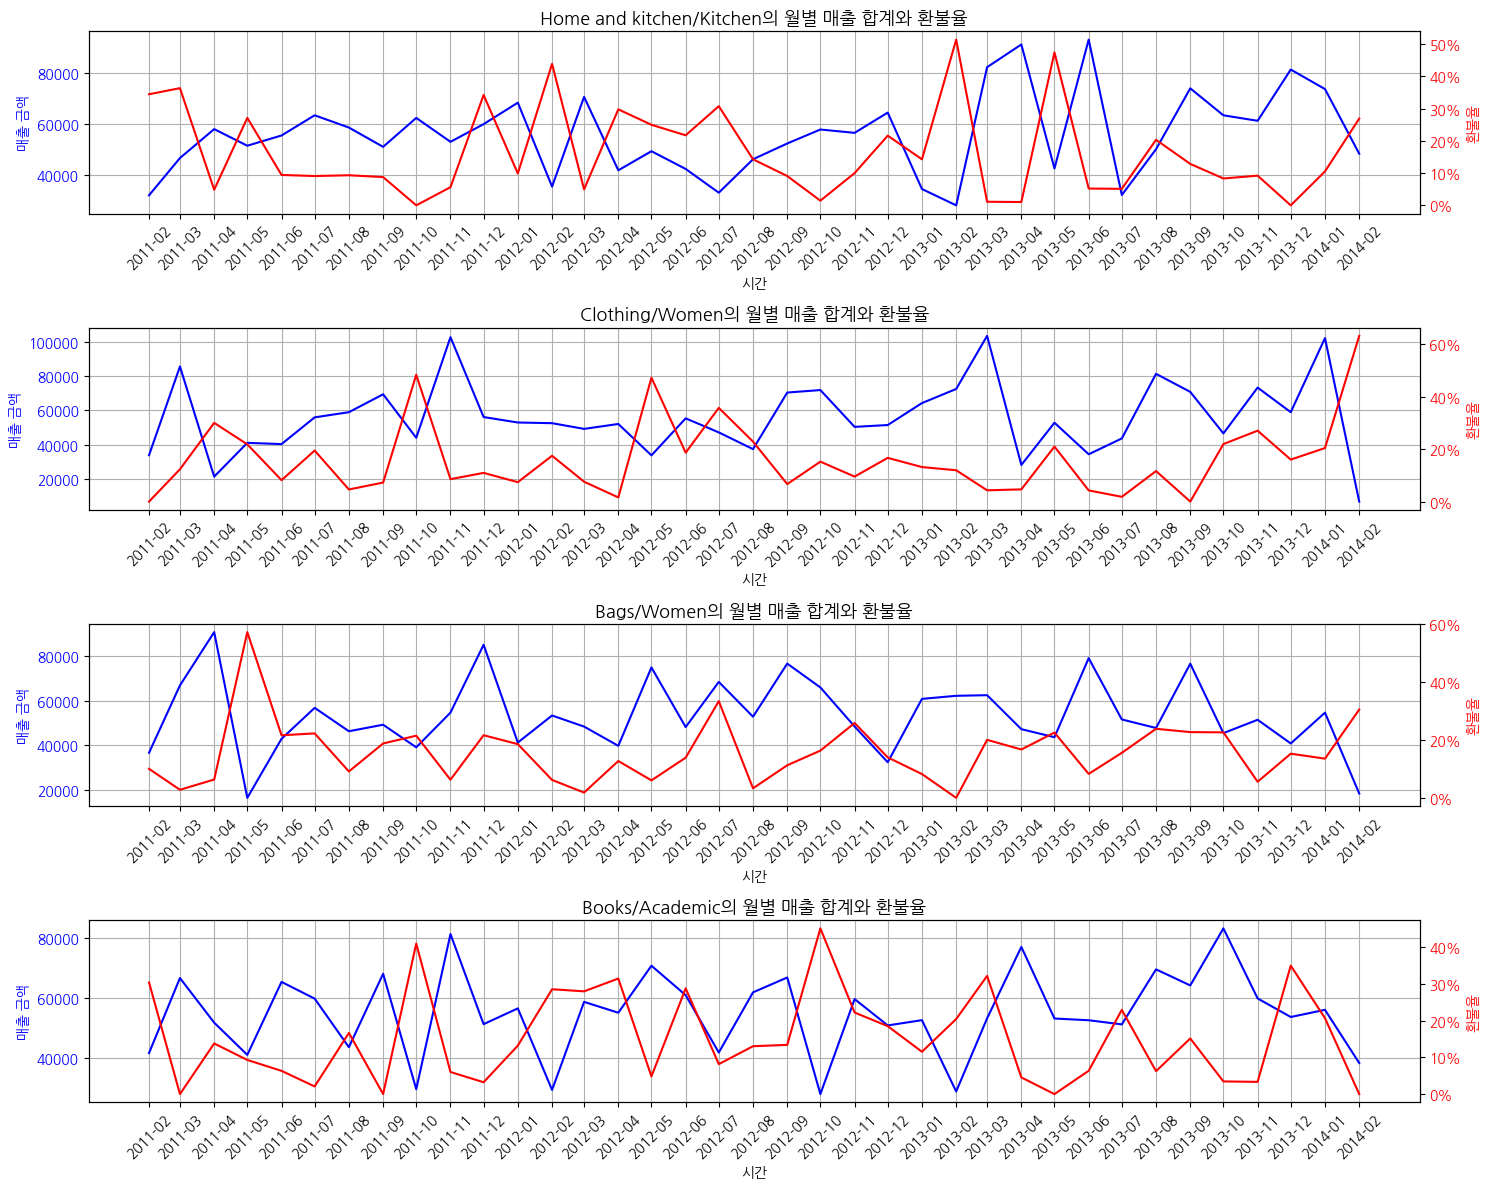

In [61]:
import matplotlib.ticker as ticker

# 시간에 따른 카테고리별 매출과 환불율 시각화하기
fig, ax1 = plt.subplots(len(sub15_df.columns), 1, figsize=(15, 12))  # 전체 그래프의 크기 설정
for count, column in enumerate(sub15_df.columns, start=0):
    ax1[count].plot(sub15_df[column].index, sub15_df[column].values, color='b')
    ax1[count].set_title(f'{column}의 월별 매출 합계와 환불율', fontsize=13)
    ax1[count].set_xlabel('시간', fontsize=10)
    ax1[count].set_ylabel('매출 금액', fontsize=10, color='b')
    ax1[count].tick_params(axis='y', labelcolor='b')
    ax1[count].grid(True)

    # 첫 번째 두 번째 축 (판매 채널)
    ax2 = ax1[count].twinx()
    ax2.plot(per_refund_df[column].index, per_refund_df[column].values, color='r')
    ax2.set_ylabel('환불율', fontsize=10, color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    # 각 축을 따로 설정해줘야 함
    ax2.yaxis.label.set_color('r')

    # x축 라벨 설정
    ax1[count].set_xticks(sub15_df.index)
    ax1[count].set_xticklabels([x.strftime('%Y-%m') for x in sub15_df.index], rotation=45)
    # y축 라벨에 음수 기호 추가
    formatter = ticker.FuncFormatter(lambda x, _: f'{abs(int(x))}%')  # 절대값과 % 추가
    ax2.yaxis.set_major_formatter(formatter)
    ax2.invert_yaxis()
plt.tight_layout()
plt.show()


## 대시보드 만들기

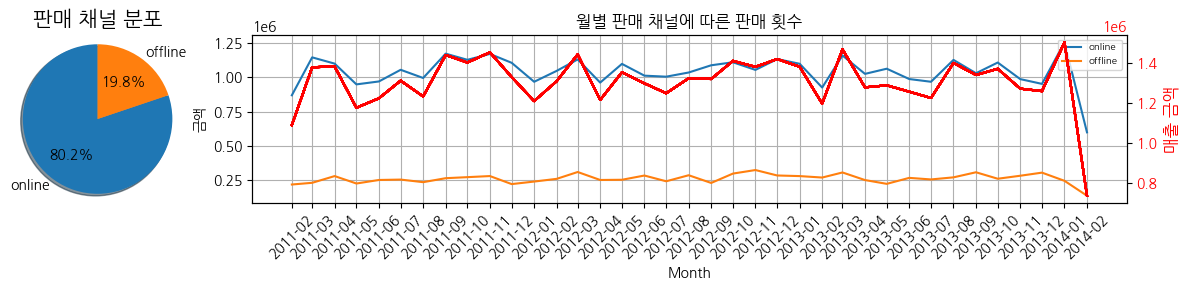

In [62]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

# 그림을 나타낼 크기 설정
fig = plt.figure(figsize=(12, 3))
gs = GridSpec(1, 5, figure=fig)

# 파이그래프 2
ax1 = fig.add_subplot(gs[0, :1])
ax1.pie(on_off_counts, labels=on_off_counts.index, autopct='%1.1f%%', startangle=90, shadow=True)
ax1.set_title('판매 채널 분포', fontsize=15)
ax1.axis('equal')

# 선 그래프
ax2 = fig.add_subplot(gs[0, 1:])
for store_type in reversed(on_off_group.columns):
    ax2.plot(on_off_group.index, on_off_group[store_type], label=store_type)

ax2.set_title('월별 판매 채널에 따른 판매 횟수')
ax2.set_xlabel('Month')
ax2.set_ylabel('금액')
ax2.set_xticks(on_off_group.index)
ax2.set_xticklabels([x.strftime('%Y-%m') for x in on_off_group.index], rotation=45)

ax2.grid(True)

# 이중 축을 사용하여 판매 채널에 따른 월별 매출 합계 그래프 그리기
ax3 = ax2.twinx()  # 이중 축 설정
for count, column in enumerate(big_sum_df, start=0):
    ax3.plot(big_sum_df.index, big_sum_df.values, color='r', linestyle='-', label=f'{column} 매출')
    ax3.set_ylabel('매출 금액', fontsize=12, color='r')
    ax3.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right', fontsize=7)
# 여백 조정
plt.tight_layout()

# 그래프 출력
plt.show()

In [63]:
cate_tran_df = join_df[join_df['Qty']>0].groupby(['on_off','prod_cat']).sum()['Qty'].unstack().sum(axis=0)
# 카테고리별 전채 거래 횟수
cate_tran_df

# 전체 환불 수량 합계
refund_qty = -join_df[join_df['Qty'] < 0].sum(axis=0)['Qty']
tran_qty = join_df.sum(axis=0)['Qty']

qty_pie = [refund_qty, tran_qty]

<ipython-input-63-2773a0b20247>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cate_tran_df = join_df[join_df['Qty']>0].groupby(['on_off','prod_cat']).sum()['Qty'].unstack().sum(axis=0)
<ipython-input-63-2773a0b20247>:6: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  refund_qty = -join_df[join_df['Qty'] < 0].sum(axis=0)['Qty']
<ipython-input-63-2773a0b20247>:7: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns

In [64]:
# 전체 환불 수량 합계
refund_online_qty = join_df[(join_df['Qty'] < 0) &( join_df['on_off']=='online')].sum(axis=0)['Qty']

(refund_online_qty/refund_qty * 100).round(2)

<ipython-input-64-08460c092be1>:2: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  refund_online_qty = join_df[(join_df['Qty'] < 0) &( join_df['on_off']=='online')].sum(axis=0)['Qty']


-80.0

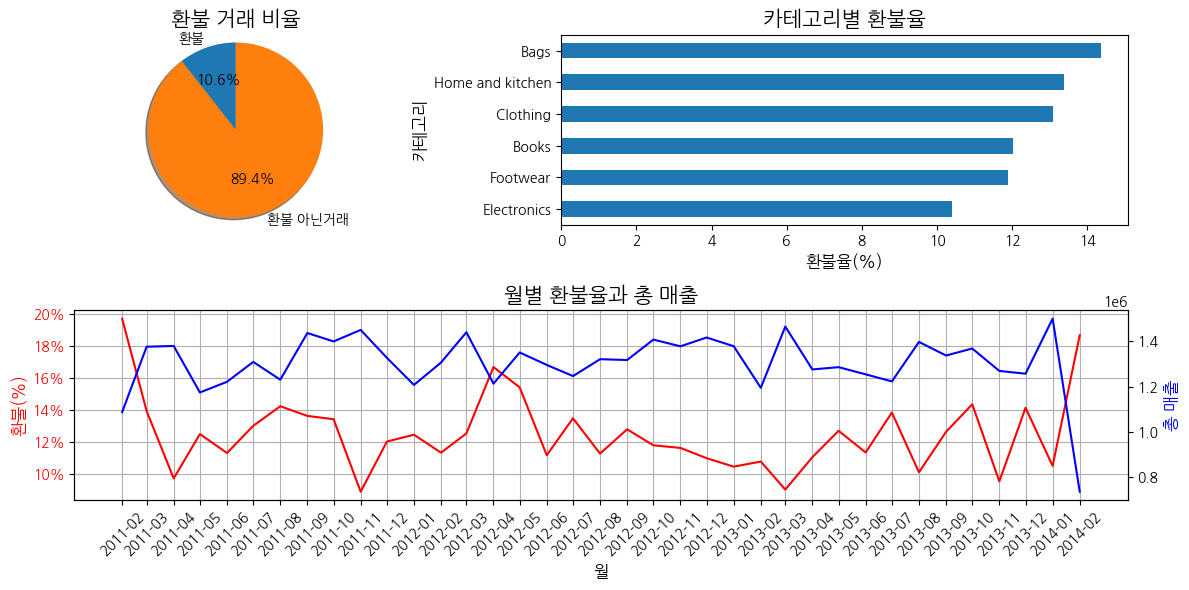

In [65]:
# 그림을 나타낼 크기 설정
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 5, figure=fig)
label = ['환불', '환불 아닌거래']
# 파이차트
ax1 = fig.add_subplot(gs[0, :2])
ax1.pie(qty_pie, labels=label, autopct='%1.1f%%', startangle=90, shadow=True)
ax1.set_title('환불 거래 비율', fontsize=15)
ax1.axis('equal')

# 막대 그래프 2
ax2 = fig.add_subplot(gs[0, 2:])
per_refund_big.plot(kind='barh', ax=ax2)
ax2.set_title('카테고리별 환불율', fontsize=15)
ax2.set_xlabel('환불율(%)', fontsize=12)
ax2.set_ylabel('카테고리', fontsize=12)
ax2.invert_yaxis()  # y축 순서 반전



# 선 그래프
ax4 = fig.add_subplot(gs[1, :])
ax4.plot(refund_total_df.index, -refund_total_df.values, color='r')
ax4.set_title('월별 환불율과 총 매출', fontsize=15)
ax4.set_xlabel('월', fontsize=12)
ax4.set_ylabel('환불(%)', fontsize=12, color='r')
ax4.tick_params(axis='y', labelcolor='r')
ax4.grid(True)

# 두 번째 축 (총 매출)
ax5 = ax4.twinx()
ax5.plot(total_df.index, total_df['total_amt'], color='b')
ax5.set_ylabel('총 매출', fontsize=12, color='b')
ax5.yaxis.label.set_color('b')

# x축 라벨 설정
ax4.set_xticks(total_df.index)
ax4.set_xticklabels([x.strftime('%Y-%m') for x in total_df.index], rotation=45)

# y축 라벨에 음수 기호 추가
formatter = ticker.FuncFormatter(lambda x, _: f'{abs(int(x))}%')  # 절대값과 % 추가
ax4.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()


In [66]:
import pandas as pd
import numpy as np

# total_amt와 -refund_total_df 간의 상관계수 계산
correlation = np.corrcoef(total_df['Qty'], -refund_total_df)

print("두 변수 간의 상관계수:", correlation[0, 1])

두 변수 간의 상관계수: -0.5695064232113975


In [67]:
a= join_df[join_df['Qty']>0].groupby('tran_date').sum()['total_amt']
b =join_df[join_df['Qty']<0].groupby('tran_date').sum()['total_amt']

<ipython-input-67-f1b76a222f04>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  a= join_df[join_df['Qty']>0].groupby('tran_date').sum()['total_amt']
<ipython-input-67-f1b76a222f04>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  b =join_df[join_df['Qty']<0].groupby('tran_date').sum()['total_amt']


In [68]:
a

tran_date
2011-02-01    60124.155
2011-02-02    39616.460
2011-02-03    26847.080
2011-02-04    70672.485
2011-02-05    34818.550
                ...    
2014-02-16    47419.970
2014-02-17    29334.435
2014-02-18    37508.120
2014-02-19    47801.195
2014-02-20    54969.330
Name: total_amt, Length: 1116, dtype: float64

In [69]:
# 두 데이터프레임 병합
merged_df = pd.merge(a, b, left_index=True, right_index=True, how='outer')

# 보간(interpolation)을 사용하여 일치하지 않은 인덱스의 데이터 일치시키기
merged_df_interpolated = merged_df.interpolate(method='time')

# 일치하지 않은 인덱스를 보간하여 데이터가 일치되었는지 확인
print(merged_df_interpolated)

            total_amt_x  total_amt_y
tran_date                           
2011-02-01    60124.155    -6095.180
2011-02-02    39616.460    -8647.730
2011-02-03    26847.080    -3377.985
2011-02-04    70672.485   -11847.810
2011-02-05    34818.550   -12253.345
...                 ...          ...
2014-02-22    54969.330    -5965.895
2014-02-23    54969.330    -3569.150
2014-02-24    54969.330    -6266.455
2014-02-27    54969.330    -8270.925
2014-02-28    54969.330    -4265.300

[1122 rows x 2 columns]


In [70]:
# 두 데이터프레임 병합
merged_df = pd.merge(a, b, left_index=True, right_index=True, how='inner')
merged_df

total_amt_x  total_amt_y
tran_date                           
2011-02-01    60124.155    -6095.180
2011-02-02    39616.460    -8647.730
2011-02-03    26847.080    -3377.985
2011-02-04    70672.485   -11847.810
2011-02-05    34818.550   -12253.345
...                 ...          ...
2014-02-13    37852.880    -1975.740
2014-02-14    42057.405     -967.980
2014-02-17    29334.435    -1320.475
2014-02-18    37508.120    -4634.370
2014-02-20    54969.330     -940.355

[945 rows x 2 columns]

In [71]:
correlation = np.corrcoef(merged_df['total_amt_x'],-merged_df['total_amt_x'])

print("두 변수 간의 상관계수:", correlation[0, 1])

두 변수 간의 상관계수: -1.0


In [72]:
join_df

category_code  transaction_id  cust_id  tran_date  Qty  Rate      Tax  \
0                101     80712190438   270351 2014-02-28   -5  -772  405.300   
1                305     29258453508   270384 2014-02-27   -5 -1497  785.925   
2                506     51750724947   273420 2014-02-24   -2  -791  166.110   
3                611     93274880719   271509 2014-02-24   -3 -1363  429.345   
4                506     51750724947   273420 2014-02-23   -2  -791  166.110   
...              ...             ...      ...        ...  ...   ...      ...   
22907            305     80348907828   267124 2011-02-01    2   552  115.920   
22908            512     83849473598   269958 2011-02-01    3   403  126.945   
22909            304     95376486237   269403 2011-02-01    5   673  353.325   
22910            203     81365620177   274222 2011-02-01    3   373  117.495   
22911            401     85848725285   271131 2011-02-01    5  1043  547.575   

       total_amt Store_type tran_month          category_name  \
0      -4265.300     e-Shop 2014-02-01         Clothing/Women   
1      -8270.925     e-Shop 2014-02-01  Electronics/Computers   
2      -1748.110   TeleShop 2014-02-01              Books/DIY   
3      -4518.345     e-Shop 2014-02-01  Home and kitchen/Bath   
4      -1748.110   TeleShop 2014-02-01              Books/DIY   
...          ...        ...        ...                    ...   
22907   1219.920   TeleShop 2011-02-01  Electronics/Computers   
22908   1335.945     e-Shop 2011-02-01         Books/Academic   
22909   3718.325        MBR 2011-02-01    Electronics/Mobiles   
22910   1236.495     e-Shop 2011-02-01         Footwear/Women   
22911   5762.575     e-Shop 2011-02-01              Bags/Mens   

               prod_cat  on_off  
0              Clothing  online  
1           Electronics  online  
2                 Books  online  
3      Home and kitchen  online  
4                 Books  online  
...                 ...     ...  
22907       Electronics  online  
22908             Books  online  
22909       Electronics  online  
22910          Footwear  online  
22911              Bags  online  

[22912 rows x 13 columns]

In [178]:
import pandas as pd
from scipy.stats import ttest_ind

# 각 카테고리별로 t-검정 수행
categories = join_df['category_name'].unique()
significant_categories = []  # 유의미한 차이가 있는 카테고리를 저장할 리스트

for category in categories:
    # 해당 카테고리의 온라인과 오프라인 판매 데이터 추출
    online_sales = join_df[(join_df['category_name'] == category) & (join_df['on_off'] == 'online')]
    offline_sales = join_df[(join_df['category_name'] == category) & (join_df['on_off'] == 'offline')]

    # t-검정 수행
    t_statistic, p_value = ttest_ind(online_sales['Qty'], offline_sales['Qty'])

    if p_value < 0.05:  # 유의수준 0.05로 설정
        significant_categories.append(category)  # 유의미한 차이가 있는 카테고리를 리스트에 추가
# 유의미한 차이가 있는 카테고리 출력
if len(significant_categories) > 0:
    print("유의미한 차이가 있는 카테고리:", significant_categories)
else:
    print("모든 카테고리는 판매채널에 따라 매출에 유의미한 차이가 없습니다")

모든 카테고리는 판매채널에 따라 매출에 유의미한 차이가 없습니다


<ipython-input-74-9788818b3c38>:18: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


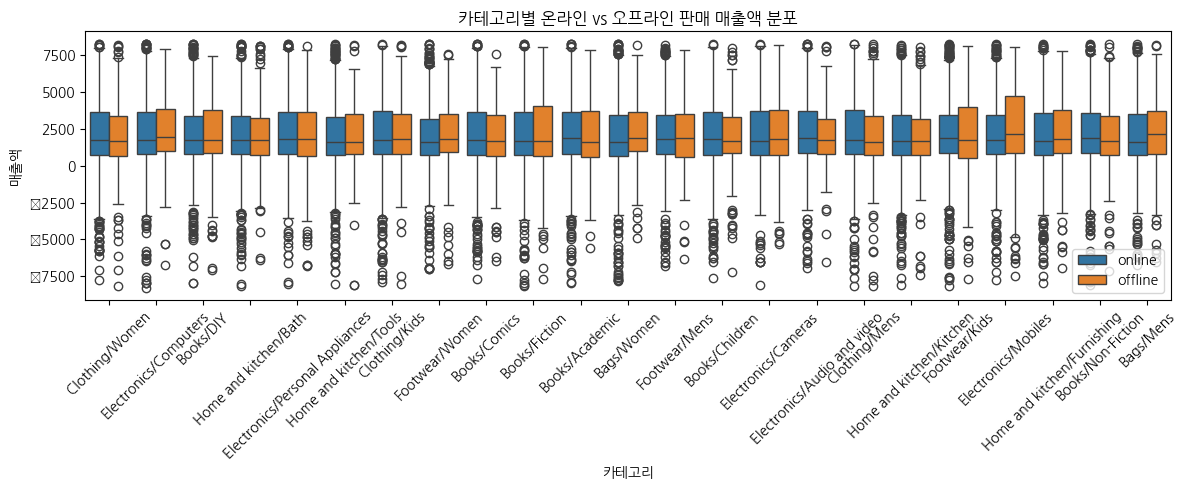

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 온라인과 오프라인 판매의 매출액 데이터 추출
online_sales = join_df[join_df['on_off'] == 'online']
offline_sales = join_df[join_df['on_off'] == 'offline']

# 상자 그림으로 시각화
plt.figure(figsize=(12, 5))
sns.boxplot(x='category_name', y='total_amt', hue='on_off', data=join_df)
plt.xticks(ticks=range(len(join_df['category_name'].unique())), labels=join_df['category_name'].unique(),rotation=45)  # x축 라벨 회전
plt.title('카테고리별 온라인 vs 오프라인 판매 매출액 분포')
plt.xlabel('카테고리')
plt.ylabel('매출액')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [116]:
# 환불율이 가장낮은 3개의 카테고리 필터링
big_refund3 = per_refund_big_df.mean().sort_values().head(3).index
list(big_refund3)

['Bags', 'Home and kitchen', 'Clothing']

In [77]:
len(big_df[big_refund3])

37

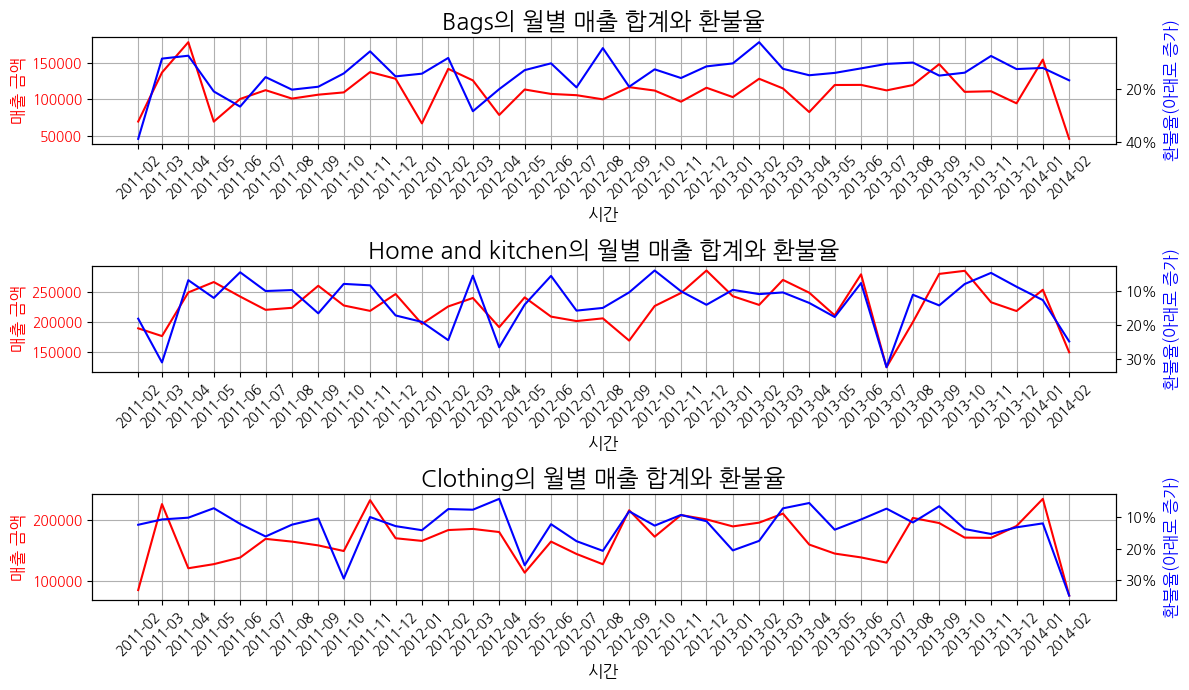

In [79]:
import matplotlib.ticker as ticker

# 시간에 따른 카테고리별 매출과 환불율 시각화하기
fig, ax1 = plt.subplots(3, 1, figsize=(12, 7))  # 전체 그래프의 크기 설정
for count, column in enumerate(big_df[big_refund3], start=0):
    ax1[count].plot(big_df[column].index, big_df[column].values, color='r')
    ax1[count].set_title(f'{column}의 월별 매출 합계와 환불율', fontsize=17)
    ax1[count].set_xlabel('시간', fontsize=12)
    ax1[count].set_ylabel('매출 금액', fontsize=12, color='r')
    ax1[count].tick_params(axis='y', labelcolor='r')
    ax1[count].grid(True)

    # 첫 번째 두 번째 축 (판매 채널)
    ax2 = ax1[count].twinx()
    ax2.plot(per_refund_big_df[column].index, per_refund_big_df[column].values, color='b')
    ax2.set_ylabel('환불율(아래로 증가)', fontsize=12, color='b')
    # 각 축을 따로 설정해줘야 함
    ax2.yaxis.label.set_color('b')

    # x축 라벨 설정
    ax1[count].set_xticks(big_df.index)
    ax1[count].set_xticklabels([x.strftime('%Y-%m') for x in big_df.index], rotation=45)

    # y축 라벨에 음수 기호 추가
    formatter = ticker.FuncFormatter(lambda x, _: f'{abs(int(x))}%')  # 절대값과 % 추가
    ax2.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()


In [101]:
a = per_refund_big_df[big_refund3].rename(columns={'Bags': 'refund_Bags', 'Home and kitchen': 'refund_Home and kitchen', 'Clothing' : 'refund_Clothing'})
b = big_df[big_refund3].rename(columns={'Bags': 'amt_Bags', 'Home and kitchen': 'amt_Home and kitchen', 'Clothing' : 'amt_Clothing'})

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


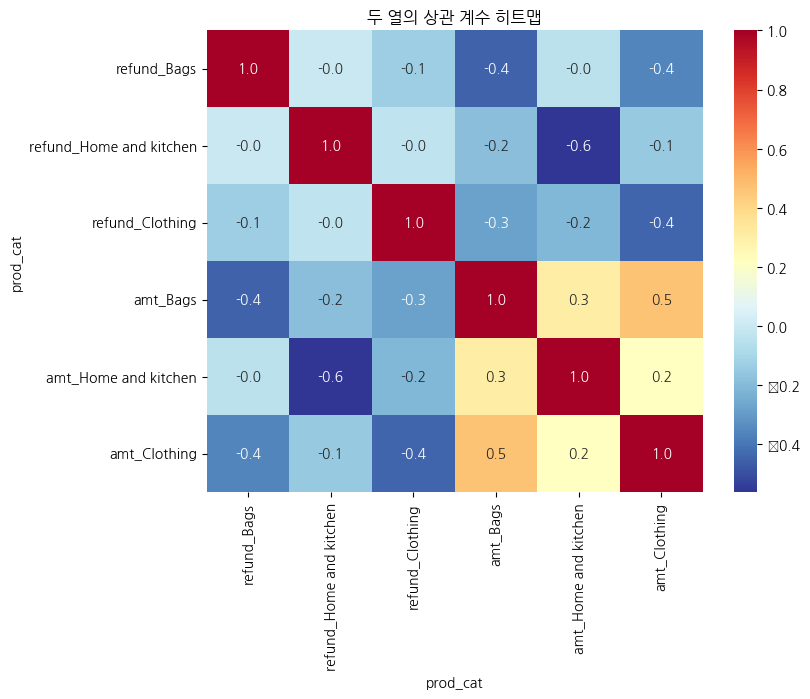

In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 두 열을 합친 데이터프레임 생성
merged_df = pd.concat([a, -b], axis=1)

# 상관 계수 계산
correlation_df = merged_df.corr()

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df, annot=True, cmap='RdYlBu_r', fmt=".2f",cbar=True)
plt.title('두 열의 상관 계수 히트맵')
plt.show()


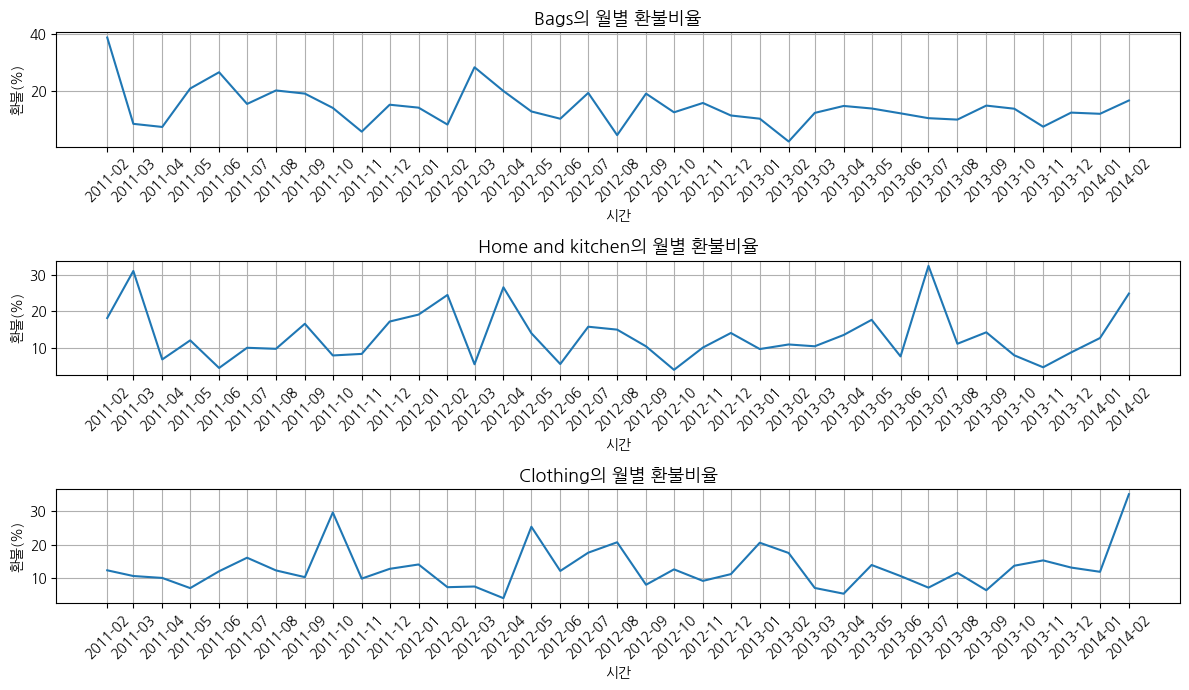

In [119]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

# 시간에 따른 특정 카테고리들의 매출 금액 시각화
categories = ['Bags', 'Home and kitchen', 'Clothing']
plt.figure(figsize=(12, 7))  # 전체 그래프의 크기 설정
for i, category in enumerate(categories, 1):
    plt.subplot(len(categories), 1, i)  # 서브플롯 생성
    plt.plot(per_refund_big_df.index, per_refund_big_df[category])
    plt.title(f'{category}의 월별 환불비율', fontsize=13)
    plt.xlabel('시간', fontsize=10)
    plt.ylabel('환불(%)', fontsize=10)
    plt.xticks(per_refund_big_df.index, [x.strftime('%Y-%m') for x in per_refund_big_df.index], rotation=45)
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(neg_to_pos))
    plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


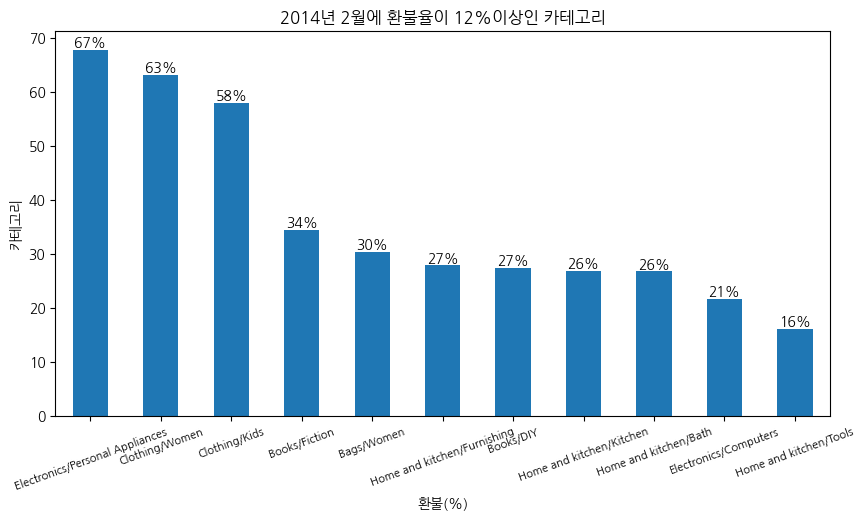

In [201]:
# 값이 0이 아닌 열 필터링
last_row_filtered = -per_refund_df.iloc[-1][per_refund_df.iloc[-1] < -12].sort_values()

# 막대 그래프 시각화
plt.figure(figsize=(10, 5))
bar_plot = last_row_filtered.plot(kind='bar')
plt.title('2014년 2월에 환불율이 12%이상인 카테고리')
plt.xlabel('환불(%)')
plt.ylabel('카테고리')
plt.xticks(rotation=20, fontsize=8)

# 막대 위에 값 표시
for index, value in enumerate(last_row_filtered):
    bar_plot.text(index, value + 0.5, f'{int(value)}%', ha='center')

plt.show()

In [193]:
list

category_name
Electronics/Personal Appliances    67.857143
Clothing/Women                     63.157895
Clothing/Kids                      58.064516
Books/Fiction                      34.482759
Bags/Women                         30.434783
Home and kitchen/Furnishing        27.906977
Books/DIY                          27.500000
Home and kitchen/Kitchen           26.923077
Home and kitchen/Bath              26.829268
Electronics/Computers              21.739130
Home and kitchen/Tools             16.216216
Name: 2014-02-01 00:00:00, dtype: float64

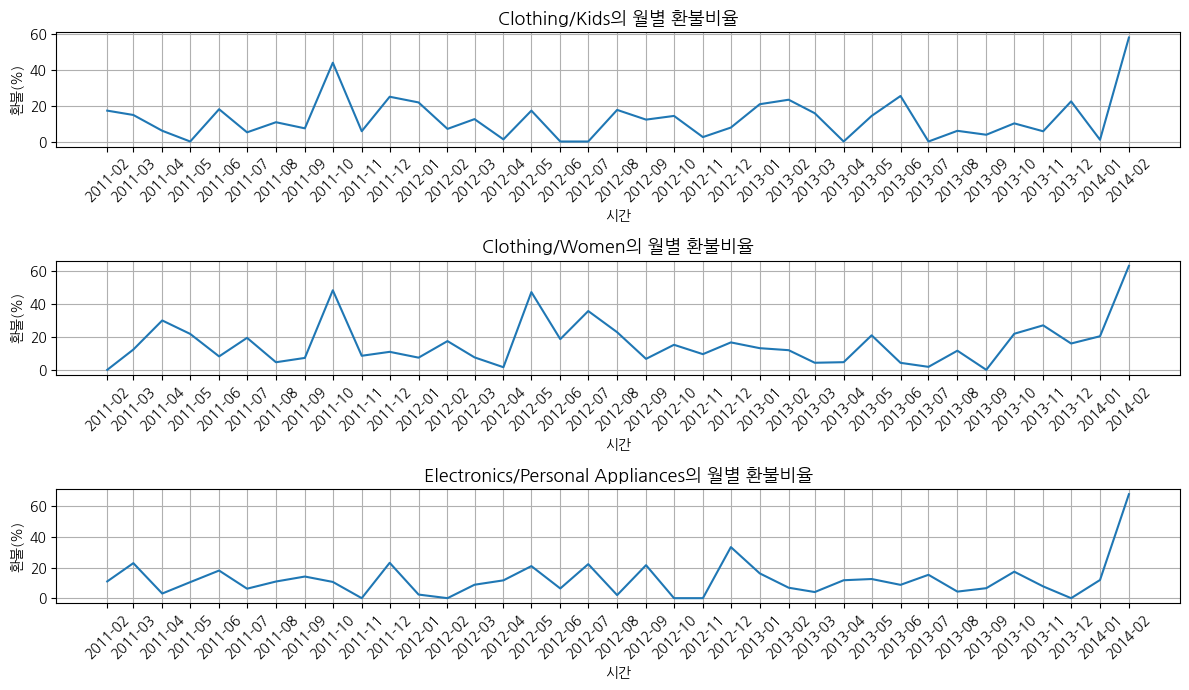

In [145]:
# 시간에 따른 카테고리별 매출 금액 시각화하기
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

# 시간에 따른 특정 카테고리들의 매출 금액 시각화
categories = ['Clothing/Kids','Clothing/Women','Electronics/Personal Appliances']
plt.figure(figsize=(12, 7))  # 전체 그래프의 크기 설정
for i, category in enumerate(categories, 1):
    plt.subplot(len(categories), 1, i)  # 서브플롯 생성
    plt.plot(per_refund_df.index, per_refund_df[category])
    plt.title(f'{category}의 월별 환불비율', fontsize=13)
    plt.xlabel('시간', fontsize=10)
    plt.ylabel('환불(%)', fontsize=10)
    plt.xticks(per_refund_df.index, [x.strftime('%Y-%m') for x in per_refund_df.index], rotation=45)
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(neg_to_pos))
    plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [181]:
refund_df[refund_df['tran_month']=='2014-02-01']

KeyError: 'tran_month'

tran_month
2011-02-01    -7
2011-03-01   -16
2011-04-01    -2
2011-05-01    -9
2011-06-01   -11
2011-07-01    -7
2011-08-01    -5
2011-09-01   -12
2011-10-01    -7
2011-11-01     0
2011-12-01   -12
2012-01-01    -2
2012-02-01     0
2012-03-01    -5
2012-04-01    -5
2012-05-01    -9
2012-06-01    -5
2012-07-01   -10
2012-08-01    -1
2012-09-01   -14
2012-10-01     0
2012-11-01     0
2012-12-01   -19
2013-01-01   -11
2013-02-01    -3
2013-03-01    -4
2013-04-01   -11
2013-05-01    -6
2013-06-01    -6
2013-07-01    -9
2013-08-01    -3
2013-09-01    -3
2013-10-01   -14
2013-11-01    -5
2013-12-01     0
2014-01-01    -7
2014-02-01   -19
Name: Electronics/Personal Appliances, dtype: int64